##### Extraction des caractéristiques prediction et calcul du taux de pauvreté sur l'ensemble training en Urbain

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

X = 50
moitiequarts = 'moitie'
Y = 100
Data_milieu='Data_urbain'

#2 Définit les chemins et charge les données.


BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
COUNTRIES_DIR = os.path.join(BASE_DIR, f'{Data_milieu}','CIV')
PROCESSED_DIR = os.path.join(BASE_DIR,f'{Data_milieu}', 'processed') 

RESULTS_DIR = os.path.join(BASE_DIR,f'{Data_milieu}','results')
CNN_TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, f'{Data_milieu}/cnn_images_{X}m_{moitiequarts}_IPM_{Y}')


CNN_SAVE_DIR = os.path.join(BASE_DIR, f'models_{X}m_{moitiequarts}_IPM_{Y}') #J'aurais du changer en y ajoutant f'{Data_milieu} 
                                                                             #pour faire la distinction entre le urbain et le rural

CNN_DIR = os.path.join(CNN_SAVE_DIR, f'trained_model_{X}m_{moitiequarts}_IPM_{Y}_vgg11bn.pt') #J'aurais du changer en y ajoutant f'{Data_milieu}

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(os.path.join(RESULTS_DIR, 'CIV_2018'), exist_ok=True)

df_images = pd.read_csv(os.path.join(PROCESSED_DIR, f'image_download_actual_{X}m_{moitiequarts}_IPM_{Y}.csv'))
df_images

#3 Charge et configure le modèle.
# Importe la bibliothèque PyTorch
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} as backend')
model = torch.load(CNN_DIR, map_location=device)
model.classifier = model.classifier[:4]
model.eval()
#4 Déclare une classe personnalisée pour le chargement rapide des images.

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class ForwardPassDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, transformer):
        self.image_dir = image_dir
        self.image_list = os.listdir(self.image_dir)
        self.transformer = transformer

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        image_name = self.image_list[index]
        X = self.filename_to_im_tensor(self.image_dir + '/' + image_name)
        return X, -1
    
    def filename_to_im_tensor(self, file):
        im = plt.imread(file)[:, :, :3]
        im = self.transformer(im)
        return im

#Définit une fonction pour extraire les caractéristiques à partir des images.

def extract_features(image_dir, classes, model, transformer, device):
    features = []
    image_order = []
    for c in classes:
        dataset = ForwardPassDataset(os.path.join(image_dir, str(c)), transformer)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False, num_workers=0)
        image_order += dataset.image_list
        for inputs, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().detach().numpy())
    features = np.vstack(features)
    return features, image_order


classes = [0, 1, 2, 3, 4, 5]



Using cuda as backend


In [2]:
#5 Extrait les caractéristiques pour les ensembles de validation et d'entraînement.

# Extraction des features pour le set d'entraînement
feats_training, image_order_training = extract_features(os.path.join(CNN_TRAIN_IMAGE_DIR, f'train_{X}m_{moitiequarts}_IPM_{Y}'), classes, model, transformer, device)
print("Dimensions de 'feats_training':", feats_training.shape)

  0%|          | 0/3800 [00:00<?, ?it/s]

  0%|          | 0/1400 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

  0%|          | 0/1413 [00:00<?, ?it/s]

  0%|          | 0/2675 [00:00<?, ?it/s]

  0%|          | 0/1488 [00:00<?, ?it/s]

Dimensions de 'feats_training': (88000, 4096)


In [4]:
df_images

,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins
0,10.0052188_-5.9011314_1.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
1,10.0052188_-5.9011314_10.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
2,10.0052188_-5.9011314_100.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
3,10.0052188_-5.9011314_11.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
4,10.0052188_-5.9011314_12.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
...,...,...,...,...,...,...,...,...,...,...
526695,9.99659178312868_-7.83548598177731_95.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0
526696,9.99659178312868_-7.83548598177731_96.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0
526697,9.99659178312868_-7.83548598177731_97.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0
526698,9.99659178312868_-7.83548598177731_98.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0


In [5]:
# Création du DataFrame pour le set d'entraînement
df_train = pd.DataFrame({
    'image_name': image_order_training,
    'feat_index': np.arange(len(image_order_training))
})

# Fusion du DataFrame df_train avec df_images sur 'image_name'
df_consumption_train = pd.merge(df_images, df_train, on='image_name')

# Ajout des caractéristiques au DataFrame df_consumption_train
for i in range(feats_training.shape[1]):
    df_consumption_train[f'feature_{i}'] = feats_training[df_consumption_train['feat_index'], i]

# Sauvegarde du DataFrame df_consumption_train
output_train_path = os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv')
df_consumption_train.to_csv(output_train_path, index=False)
print(f"DataFrame pour le set d'entraînement sauvegardé à {output_train_path}") 


C:\Users\Dell\AppData\Local\Temp\ipykernel_16500\2166723369.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_consumption_train[f'feature_{i}'] = feats_training[df_consumption_train['feat_index'], i]
C:\Users\Dell\AppData\Local\Temp\ipykernel_16500\2166723369.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_consumption_train[f'feature_{i}'] = feats_training[df_consumption_train['feat_index'], i]
C:\Users\Dell\AppData\Local\Temp\ipykernel_16500\2166723369.py:12: PerformanceWarning: DataFrame is highly fragmented.  Th

DataFrame pour le set d'entraînement sauvegardé à D:\Poverty_Predict_Par_Milieu\df_consumption_train_50m_moitie_IPM_100_Data_urbain.csv


In [6]:
df_consumption_train

,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
0,10.0074722_-5.9032249_1.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,0.450833,1.226787,-0.721878,-0.047199,-1.308045,0.921614,0.266016,1.068446,-0.679003,-2.041007
1,10.0074722_-5.9032249_10.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,1.295256,1.651784,-1.478511,-0.376489,-1.273421,1.767620,2.235622,0.224600,-0.835752,-2.443339
2,10.0074722_-5.9032249_100.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,1.164467,1.735679,-0.727439,-0.420583,-1.083289,1.943229,2.413110,0.416395,-0.343440,-2.152441
3,10.0074722_-5.9032249_11.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,0.917741,2.219799,-0.604809,-0.256783,-0.301074,1.384768,2.337878,0.163616,-0.393719,-2.168289
4,10.0074722_-5.9032249_12.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,1.490670,1.791240,-1.443860,-1.042857,-1.932772,0.926367,1.590600,0.337617,-0.859144,-2.050417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,9.99416057020426_-7.83644864335656_95.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.576911,1.132550,-0.412185,-0.668878,-2.199243,-0.325278,-0.543729,0.352818,0.150859,-3.635463
87996,9.99416057020426_-7.83644864335656_96.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.492142,1.775382,-0.156162,-1.147675,-0.841010,-0.153208,0.338071,0.073486,0.636244,-2.871462
87997,9.99416057020426_-7.83644864335656_97.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.507955,1.282793,-0.143044,-0.703305,-1.416373,0.280580,-0.179370,0.489432,-0.082659,-3.648220
87998,9.99416057020426_-7.83644864335656_98.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.145731,1.205787,0.393173,-0.523426,-2.245693,-1.296187,-0.091512,0.058148,0.722753,-3.553866


In [11]:
df_consumption_train.iloc[:, 7]

0        328734.94
1        328734.94
2        328734.94
3        328734.94
4        328734.94
           ...    
87995    532673.60
87996    532673.60
87997    532673.60
87998    532673.60
87999    532673.60
Name: pcexp, Length: 88000, dtype: float64

In [9]:
df_consumption_train.iloc[:, 11:]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
0,-1.871114,0.252827,-0.053167,0.028750,0.402159,0.512778,0.476265,-1.685271,0.222689,-1.124912,...,0.450833,1.226787,-0.721878,-0.047199,-1.308045,0.921614,0.266016,1.068446,-0.679003,-2.041007
1,-1.827283,-0.787350,0.444441,0.666638,0.021649,0.530357,-0.306281,-2.027170,-0.328367,-1.293162,...,1.295256,1.651784,-1.478511,-0.376489,-1.273421,1.767620,2.235622,0.224600,-0.835752,-2.443339
2,-1.968374,-0.337856,0.648282,0.618511,-0.615164,0.685683,0.332122,-1.061077,0.433887,-0.647800,...,1.164467,1.735679,-0.727439,-0.420583,-1.083289,1.943229,2.413110,0.416395,-0.343440,-2.152441
3,-2.840154,-0.326402,0.268232,0.540097,0.008663,0.532789,0.680501,-0.777280,0.469176,-1.320444,...,0.917741,2.219799,-0.604809,-0.256783,-0.301074,1.384768,2.337878,0.163616,-0.393719,-2.168289
4,-2.640046,-1.338402,0.027906,-0.216332,-0.808112,-0.368930,-0.697721,-2.194153,0.324653,-1.817171,...,1.490670,1.791240,-1.443860,-1.042857,-1.932772,0.926367,1.590600,0.337617,-0.859144,-2.050417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,-1.356293,-0.458624,0.613440,-1.597365,-0.269412,-0.034047,-0.875599,-1.073494,2.893262,-0.653086,...,0.576911,1.132550,-0.412185,-0.668878,-2.199243,-0.325278,-0.543729,0.352818,0.150859,-3.635463
87996,-1.446967,-0.691244,-0.227580,-1.185521,-1.085335,0.549596,-0.611458,-0.404193,2.496817,0.233130,...,0.492142,1.775382,-0.156162,-1.147675,-0.841010,-0.153208,0.338071,0.073486,0.636244,-2.871462
87997,-1.152387,-1.214824,0.933887,-1.671439,-0.199648,-0.305505,-1.281311,-0.783494,2.438795,-0.598501,...,0.507955,1.282793,-0.143044,-0.703305,-1.416373,0.280580,-0.179370,0.489432,-0.082659,-3.648220
87998,-1.704313,-0.992170,0.496019,-1.244361,-0.211951,-0.668615,-0.702287,-1.184391,2.922504,-0.461622,...,0.145731,1.205787,0.393173,-0.523426,-2.245693,-1.296187,-0.091512,0.058148,0.722753,-3.553866


 ##### calcul et la visualisation de la matrice de corrélation entre les 4096 caractéristiques

In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Définir le chemin de base et charger les données
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
data_path = os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv')
df = pd.read_csv(data_path)
df


,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
0,10.0074722_-5.9032249_1.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,0.450833,1.226787,-0.721878,-0.047199,-1.308045,0.921614,0.266016,1.068446,-0.679003,-2.041007
1,10.0074722_-5.9032249_10.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,1.295256,1.651784,-1.478511,-0.376489,-1.273421,1.767620,2.235622,0.224600,-0.835753,-2.443339
2,10.0074722_-5.9032249_100.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,1.164467,1.735679,-0.727439,-0.420583,-1.083289,1.943229,2.413110,0.416395,-0.343440,-2.152441
3,10.0074722_-5.9032249_11.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,0.917741,2.219799,-0.604809,-0.256783,-0.301074,1.384769,2.337878,0.163616,-0.393720,-2.168289
4,10.0074722_-5.9032249_12.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,1.490670,1.791240,-1.443860,-1.042857,-1.932772,0.926367,1.590600,0.337617,-0.859144,-2.050417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,9.99416057020426_-7.83644864335656_95.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.576911,1.132551,-0.412185,-0.668878,-2.199243,-0.325278,-0.543729,0.352818,0.150859,-3.635463
87996,9.99416057020426_-7.83644864335656_96.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.492142,1.775382,-0.156162,-1.147675,-0.841010,-0.153208,0.338071,0.073486,0.636244,-2.871462
87997,9.99416057020426_-7.83644864335656_97.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.507955,1.282793,-0.143044,-0.703305,-1.416373,0.280580,-0.179370,0.489432,-0.082659,-3.648220
87998,9.99416057020426_-7.83644864335656_98.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,0.145732,1.205787,0.393173,-0.523426,-2.245693,-1.296187,-0.091512,0.058148,0.722753,-3.553866


In [14]:
# Préparer les données
X_urbain_train = df.iloc[:, 11:]  # Les caractéristiques
y = df.iloc[:, 7]   # 'pcexp'


In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
X_urbain_train

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4086,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095
0,-1.871114,0.252827,-0.053167,0.028750,0.402159,0.512778,0.476265,-1.685270,0.222689,-1.124912,...,0.450833,1.226787,-0.721878,-0.047199,-1.308045,0.921614,0.266016,1.068446,-0.679003,-2.041007
1,-1.827283,-0.787350,0.444441,0.666638,0.021649,0.530357,-0.306281,-2.027170,-0.328367,-1.293162,...,1.295256,1.651784,-1.478511,-0.376489,-1.273421,1.767620,2.235622,0.224600,-0.835753,-2.443339
2,-1.968374,-0.337856,0.648282,0.618511,-0.615164,0.685683,0.332122,-1.061077,0.433887,-0.647800,...,1.164467,1.735679,-0.727439,-0.420583,-1.083289,1.943229,2.413110,0.416395,-0.343440,-2.152441
3,-2.840154,-0.326402,0.268232,0.540097,0.008663,0.532789,0.680501,-0.777280,0.469176,-1.320445,...,0.917741,2.219799,-0.604809,-0.256783,-0.301074,1.384769,2.337878,0.163616,-0.393720,-2.168289
4,-2.640046,-1.338402,0.027906,-0.216332,-0.808112,-0.368930,-0.697721,-2.194153,0.324653,-1.817171,...,1.490670,1.791240,-1.443860,-1.042857,-1.932772,0.926367,1.590600,0.337617,-0.859144,-2.050417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,-1.356293,-0.458624,0.613440,-1.597365,-0.269412,-0.034047,-0.875599,-1.073494,2.893262,-0.653086,...,0.576911,1.132551,-0.412185,-0.668878,-2.199243,-0.325278,-0.543729,0.352818,0.150859,-3.635463
87996,-1.446967,-0.691244,-0.227580,-1.185521,-1.085336,0.549596,-0.611458,-0.404193,2.496817,0.233130,...,0.492142,1.775382,-0.156162,-1.147675,-0.841010,-0.153208,0.338071,0.073486,0.636244,-2.871462
87997,-1.152387,-1.214824,0.933887,-1.671439,-0.199648,-0.305505,-1.281311,-0.783494,2.438795,-0.598501,...,0.507955,1.282793,-0.143044,-0.703305,-1.416373,0.280580,-0.179370,0.489432,-0.082659,-3.648220
87998,-1.704313,-0.992170,0.496019,-1.244361,-0.211951,-0.668615,-0.702287,-1.184390,2.922504,-0.461622,...,0.145732,1.205787,0.393173,-0.523426,-2.245693,-1.296187,-0.091512,0.058148,0.722753,-3.553866


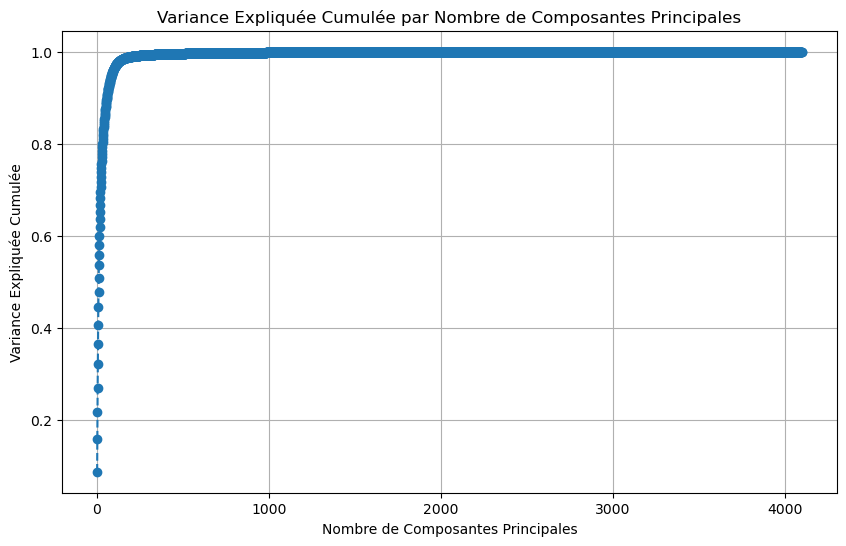

Nombre optimal de composantes principales pour expliquer 95.0% de la variance: 86


In [19]:
# Normalisation des caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_urbain_train)


# Appliquer PCA sans limiter le nombre de composantes
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculer la variance expliquée cumulée
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Tracer la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Variance Expliquée Cumulée')
plt.title('Variance Expliquée Cumulée par Nombre de Composantes Principales')
plt.grid(True)
plt.show()
# Choisir le nombre de composantes pour expliquer 95% de la variance
threshold = 0.95
n_components_optimal = np.argmax(explained_variance_ratio >= threshold) + 1
print(f'Nombre optimal de composantes principales pour expliquer {threshold * 100}% de la variance: {n_components_optimal}')


# Appliquer PCA avec le nombre optimal de composantes
pca = PCA(n_components=n_components_optimal)
X_pca = pca.fit_transform(X_scaled)


In [20]:
X_pca.shape

(88000, 86)

In [21]:
print(X_pca)

[[ -3.52369386  -1.35081047  -1.32922205 ...   1.04319912   1.05155006
   -2.31821078]
 [ 13.61666299   0.5287964   -7.494562   ...  -1.42250338  -1.4607856
    0.83791094]
 [ 15.60193552  -0.04757101 -12.51191448 ...   0.29786747  -3.40365657
   -3.02743707]
 ...
 [ 12.36266527  32.41181302 -13.55753947 ...   1.19223472   0.40672624
    3.46670755]
 [ 18.19250182  35.69231445 -12.88302436 ...   2.63435915  -0.1011424
   -1.88894949]
 [  2.50584661  23.04028619 -16.57070301 ...  -3.99640381   3.84877418
    5.18631878]]


In [22]:
#Variance expliquée par chaque composante
pca = PCA(n_components=n_components_optimal)
X_pca = pca.fit_transform(X_scaled)
print(pca.explained_variance_ratio_)

[0.08792167 0.07157652 0.05735467 0.05358488 0.05064387 0.04504974
 0.04037951 0.0381085  0.03361646 0.02959325 0.02843725 0.02255938
 0.02067272 0.02016963 0.01881838 0.01729091 0.01701945 0.01502837
 0.01464579 0.01243655 0.01156205 0.01111546 0.01061227 0.00975596
 0.00912408 0.00851574 0.00792292 0.00760766 0.00742243 0.00692167
 0.00677792 0.00638471 0.00631734 0.00581966 0.00561227 0.00533849
 0.00523275 0.00507232 0.00482606 0.00438887 0.00435961 0.00429122
 0.00419983 0.00388613 0.003705   0.00368838 0.00367177 0.00348152
 0.00339433 0.0032989  0.00319899 0.00305037 0.00295217 0.00286289
 0.00279564 0.00273934 0.00265202 0.00259581 0.00250784 0.0023841
 0.00230332 0.00228208 0.0022149  0.00217629 0.00206085 0.00204238
 0.0019792  0.00193833 0.00188959 0.00181779 0.00180241 0.00173853
 0.00171705 0.00166476 0.00157691 0.0015426  0.00150698 0.00149514
 0.00144294 0.0014178  0.00135342 0.00131854 0.00130062 0.00124756
 0.00120218 0.00115396]


In [23]:
X_pca

array([[ -3.52369386,  -1.35081047,  -1.32922205, ...,  -0.90550953,
          1.0287864 ,  -2.49099315],
       [ 13.61666299,   0.5287964 ,  -7.494562  , ...,   1.17144216,
         -1.09955775,   0.85042703],
       [ 15.60193552,  -0.04757101, -12.51191448, ...,  -0.56913652,
         -2.97918098,  -3.24798045],
       ...,
       [ 12.36266527,  32.41181302, -13.55753947, ...,  -0.57195752,
          0.08802978,   4.68257433],
       [ 18.19250182,  35.69231445, -12.88302436, ...,  -2.36634083,
         -0.23465539,  -1.24842153],
       [  2.50584661,  23.04028619, -16.57070301, ...,   4.46007473,
          3.47101017,   5.5379848 ]])

In [24]:
coefficients_des_composantes_principales=pca.components_

In [25]:
coefficients_des_composantes_principales

array([[-0.00999102, -0.00892301, -0.01412877, ...,  0.0125711 ,
         0.01147407, -0.01919678],
       [ 0.0296436 , -0.00497878,  0.01815329, ..., -0.02094659,
        -0.02237817,  0.01654838],
       [ 0.01572022, -0.00107871, -0.01281502, ..., -0.02159979,
        -0.02576575, -0.00392566],
       ...,
       [-0.00514068, -0.0012058 ,  0.00243619, ...,  0.00806571,
        -0.00813395, -0.01325809],
       [ 0.00723946,  0.01856787, -0.02690604, ..., -0.00626104,
         0.00828709,  0.01720257],
       [ 0.01799731,  0.01894908,  0.0040279 , ...,  0.00322277,
        -0.00765043,  0.00494622]])

In [26]:
coefficients_des_composantes_principales.shape

(86, 4096)

In [27]:
y.shape

(88000,)

### OLS sur le X_pca

In [28]:
from sklearn.linear_model import LinearRegression

#le modèle de régression linéaire à X_pca en tant que prédicteurs et y comme variable cible.
linear_model_pca = LinearRegression()
linear_model_pca.fit(X_pca, y)

#les coefficients de la régression
coefficients = linear_model_pca.coef_
print("Coefficients du modèle :", coefficients)



Coefficients du modèle : [ 2522.60009548 -7381.46706936  2983.46065283   780.1396647
  2566.63204755  5139.6645413   -524.87779919  1207.52467933
   693.04247999 -1607.9407261    658.38477541 -2446.90891981
  4956.04652741 -2306.60342368 -2126.44467303  -562.27584704
  -970.03392973 -3279.519785    1870.22848893 -1107.8863616
  1722.55320165 -4905.56042355  1150.72009989  -817.14955597
  1160.81391857  7230.14097212  1570.94220158 -2858.83331365
  1559.61704891  2392.21664424  1513.77856842  1639.24566861
  2654.68339821  2397.83121688  6115.66445594  4803.22541007
  1795.30484498  -630.53067146  7520.00261563 -3166.41862213
   487.83609628 -5532.63356516 -8027.02592814  5233.57699783
  1696.73793114   102.39389606  6813.3707397   6613.50835451
 -2181.98532475  -626.21960477  -375.97394523 -9200.63907016
  4942.89574993 -5191.85234967 -4228.24471637   620.11881593
  -668.18974914 -1410.56214946 -5830.64589837 -5668.87200557
  4975.26964955 -4070.04109494  6257.48038561  3498.95851485
 

In [29]:
#Résumé complet de la regression avec stats model
import statsmodels.api as sm

# Ajout d'un intercept à X_pca
X_pca_sm = sm.add_constant(X_pca)

# Ajustement du modèle avec statsmodels
model_sm = sm.OLS(y, X_pca_sm)
results = model_sm.fit()

# Affichage du résumé
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                  pcexp   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.151
Method:                 Least Squares   F-statistic:                     182.4
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:14:34   Log-Likelihood:            -1.2832e+06
No. Observations:               88000   AIC:                         2.567e+06
Df Residuals:                   87913   BIC:                         2.567e+06
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.104e+05   1756.772    404.352      0.0

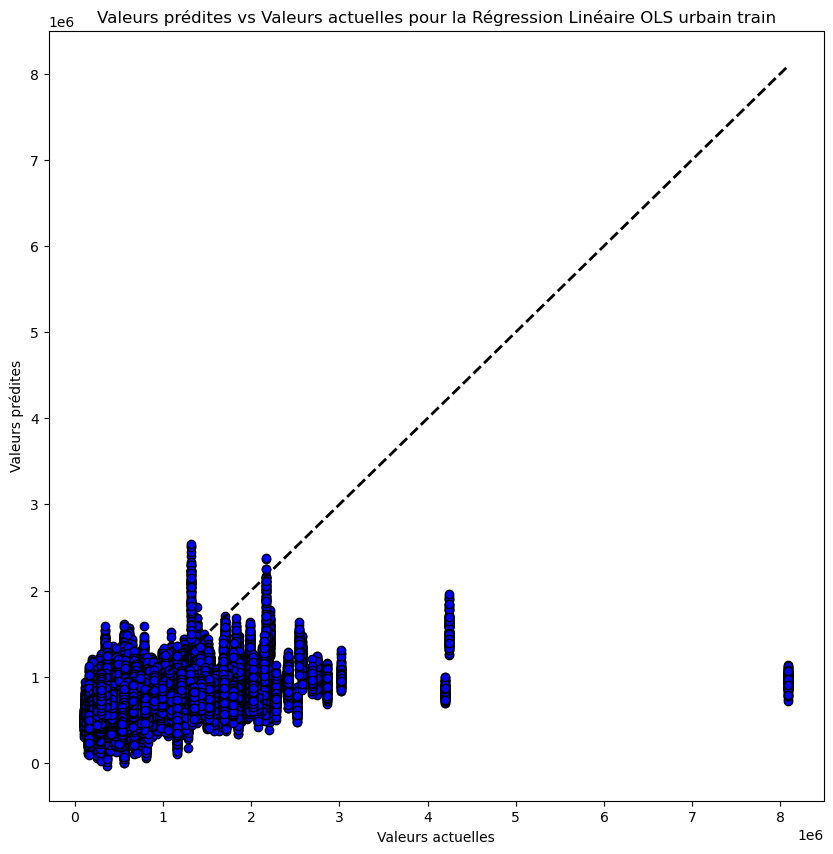

In [48]:
# Prédictions du modèle linéaire
y_pred_OLS = linear_model_pca.predict(X_pca)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 10))
plt.scatter(y, y_pred_OLS, alpha=1, color='blue', edgecolors='Black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS urbain train')
plt.show()

In [49]:
#Exportation du modèle OLS de statsmodels avec pca pour ré-utilisation 
import pickle
# Chemin de sauvegarde du modèle
model_sm_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca.pkl'
# Sauvegarder le modèle statsmodels
with open(model_sm_path, 'wb') as file:
    pickle.dump(results, file)
print(f'Modèle statsmodels sauvegardé à: {model_sm_path}')

Modèle statsmodels sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\model_sm_pca.pkl


In [51]:
'''
#Chargement du modèle OLS de statsmodels qui a été importé pour ré-utilisation 
# Chemin de sauvegarde du modèle
model_sm_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca.pkl'
# Recharger le modèle OLS librairie statsmodels
with open(model_sm_path, 'rb') as file:
    model_sm_loaded = pickle.load(file)
print("Modèle OLS de la bibliothèque statsmodels chargé avec succès.")
'''

'\n#Chargement du modèle OLS de statsmodels qui a été importé pour ré-utilisation \n# Chemin de sauvegarde du modèle\nmodel_sm_path = f\'{BASE_DIR}\\{Data_milieu}\\model_sm_pca.pkl\'\n# Recharger le modèle OLS librairie statsmodels\nwith open(model_sm_path, \'rb\') as file:\n    model_sm_loaded = pickle.load(file)\nprint("Modèle OLS de la bibliothèque statsmodels chargé avec succès.")\n'

### Ridge regression sur le X_pca

In [52]:
#Modèle de régression Ridge avec scikit-learn

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model = Ridge()
ridge_cv = GridSearchCV(ridge_model, {'alpha': alphas}, scoring='r2', cv=5)
ridge_cv.fit(X_pca, y)

# Meilleure valeur de alpha pour Ridge
best_alpha_ridge = ridge_cv.best_estimator_.alpha
print(f'Best alpha for Ridge: {best_alpha_ridge}')

Best alpha for Ridge: 1000000.0


In [56]:
# Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_pca, y)

# Extraction et affichage des coefficients du modèle Ridge
coefficients_ridge = ridge_model.coef_
print("Coefficients du modèle Ridge:", coefficients_ridge)

Coefficients du modèle Ridge: [ 2445.4355684  -7106.03521803  2845.80509993   741.73669223
  2433.33153792  4841.5071048   -491.13383044  1125.58155002
   640.20698179 -1470.11913232   599.86246482 -2178.9449549
  4369.63216736 -2027.69476162 -1853.22976697  -484.5326064
  -834.07254853 -2768.44808258  1572.37619409  -905.81792159
  1389.21066606 -3925.73118985   912.23744154  -636.22482477
   890.14955861  5453.46781779  1163.5189821  -2094.88205814
  1135.27773487  1707.72920501  1074.12143967  1142.70884412
  1844.6058965   1623.75906358  4092.57320832  3160.67473934
  1173.26010837  -407.59509441  4775.01795076 -1940.05543532
   298.12090942 -3360.21514471 -4833.86944206  3053.60077065
   970.22618951    58.43799937  3880.97286177  3680.56806369
 -1200.64636143  -340.15450674  -201.35157779 -4818.33961901
  2548.20080889 -2636.70901211 -2122.21179385   308.09207831
  -326.56441504  -681.83655782 -2768.24281822 -2620.01683445
  2256.88086846 -1836.90841496  2777.92574025  1538.14207

In [57]:
# Prédictions Ridge
y_pred_ridge = ridge_model.predict(X_pca)

# Évaluation du modèle Ridge
mse_pca_ridge = mean_squared_error(y, y_pred_ridge)
r2_pca_ridge = r2_score(y, y_pred_ridge)
mae_pca_ridge = mean_absolute_error(y, y_pred_ridge)

print(f'Ridge Train MSE: {mse_pca_ridge}')
print(f'Ridge Train MAE: {mae_pca_ridge}')
print(f'Ridge Train R^2: {r2_pca_ridge}')

Ridge Train MSE: 274611063070.24432
Ridge Train MAE: 342405.0463273491
Ridge Train R^2: 0.14111963668048055


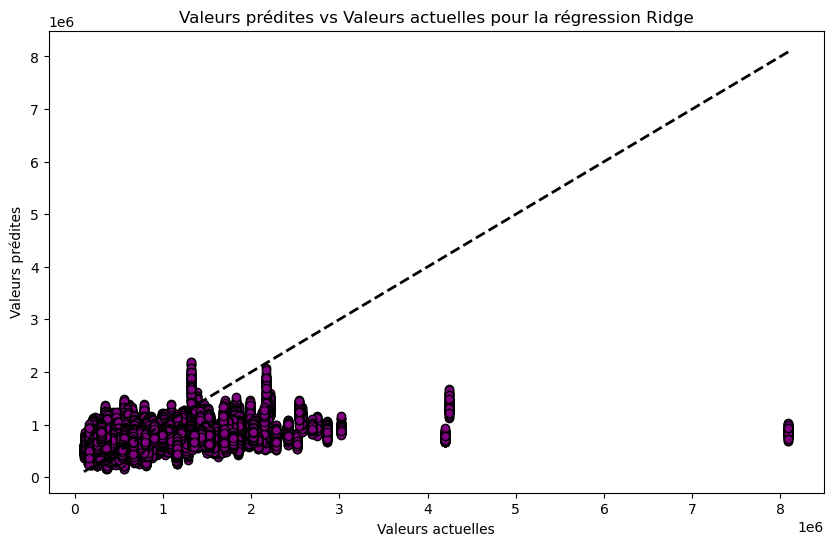

In [58]:
# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_ridge, alpha=1,color='purple', edgecolors='Black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge')
plt.show()

In [61]:
#Exportation du modèle ridge pour ré-utilisation
import joblib
# Chemin de sauvegarde du modèle
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
model_path_ridge = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca.pkl'

# Sauvegarder le modèle Ridge
joblib.dump(ridge_model, model_path_ridge)
print(f'Modèle sauvegardé à: {model_path_ridge}')


Modèle sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\ridge_model_pca.pkl


In [63]:
'''
#Chargement du modèle Ridge qui a été importé pour ré-utilisation 
# Chemin de sauvegarde du modèle
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
model_path_ridge = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca.pkl'
# Recharger le modèle Ridge
ridge_model_loaded = joblib.load(model_path_ridge)
print("Modèle de Ridge chargé avec succès.")
ridge_model_loaded.coef_
'''

'\n#Chargement du modèle Ridge qui a été importé pour ré-utilisation \n# Chemin de sauvegarde du modèle\nBASE_DIR = r\'D:\\Poverty_Predict_Par_Milieu\'\nmodel_path_ridge = f\'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca.pkl\'\n# Recharger le modèle Ridge\nridge_model_loaded = joblib.load(model_path_ridge)\nprint("Modèle de Ridge chargé avec succès.")\nridge_model_loaded.coef_\n'

### Lasso sur le X_pca

In [64]:
#Regression Lasso
# Modèle de régression Lasso avec scikit-learn

from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

In [65]:
# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
lasso_model = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso_model, {'alpha': alphas}, scoring='r2', cv=5)
lasso_cv.fit(X_pca, y)

# Meilleure valeur de alpha pour Lasso
best_alpha_lasso = lasso_cv.best_estimator_.alpha
print(f'Best alpha for Lasso: {best_alpha_lasso}')

Best alpha for Lasso: 217111.79456945008


In [66]:
# Entraîner le modèle de régression Lasso avec la meilleure valeur de alpha
lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_pca, y)

# Extraction et affichage des coefficients du modèle Lasso
coefficients_lasso = lasso_model.coef_
print("Coefficients du modèle Lasso:", coefficients_lasso)


Coefficients du modèle Lasso: [ 1919.72469496 -6640.91961235  2059.28468488     0.
  1519.99376901  3963.05826279    -0.             0.
     0.            -0.             0.           -97.29652085
  2392.00056442    -0.            -0.            -0.
    -0.            -0.             0.            -0.
     0.          -136.90520365     0.            -0.
     0.          1005.69251816     0.            -0.
     0.             0.             0.             0.
     0.             0.             0.             0.
     0.            -0.             0.            -0.
     0.            -0.            -0.             0.
     0.             0.             0.             0.
    -0.            -0.            -0.            -0.
     0.            -0.            -0.             0.
    -0.            -0.            -0.            -0.
     0.            -0.             0.             0.
    -0.            -0.            -0.             0.
    -0.            -0.            -0.             0.
     0. 

In [67]:
# Prédictions Lasso
y_pred_lasso = lasso_model.predict(X_pca)

# Évaluation du modèle Lasso
mse_pca_lasso = mean_squared_error(y, y_pred_lasso)
r2_pca_lasso = r2_score(y, y_pred_lasso)
mae_pca_lasso = mean_absolute_error(y, y_pred_lasso)

print(f'Lasso Train MSE: {mse_pca_lasso}')
print(f'Lasso Train MAE: {mae_pca_lasso}')
print(f'Lasso Train R^2: {r2_pca_lasso}')


Lasso Train MSE: 292010168561.6408
Lasso Train MAE: 353325.9306178839
Lasso Train R^2: 0.08670176334788748


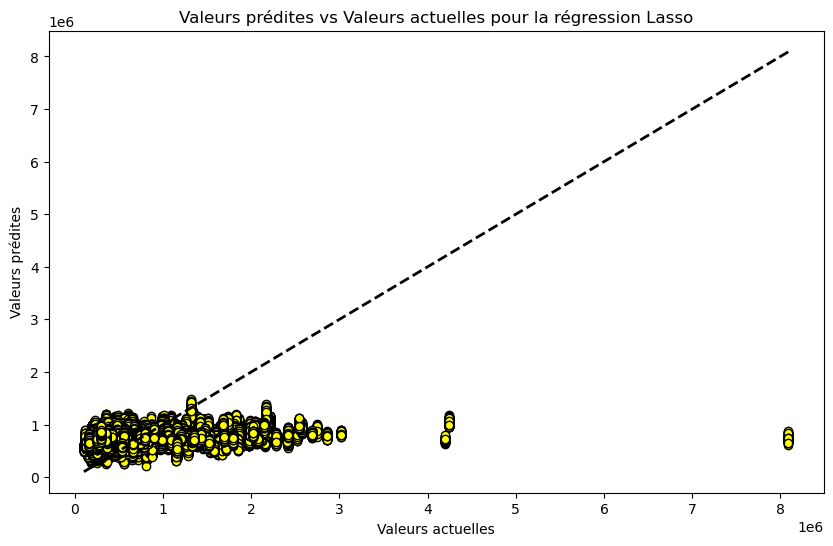

In [68]:
# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_lasso, alpha=1, color='yellow', edgecolors='black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso')
plt.show()

In [69]:
#Exportation du modèle Lasso pour ré-utilisation
import joblib
# Chemin de sauvegarde du modèle Lasso
lasso_model_path = f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca.pkl'
# Sauvegarder le modèle Lasso
joblib.dump(lasso_model, lasso_model_path)
print(f'Modèle Lasso sauvegardé à: {lasso_model_path}')

Modèle Lasso sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\lasso_model_pca.pkl


In [71]:
'''
#Chargement du modèle Lasso qui a été importé pour ré-utilisation 
import joblib
# Chemin de sauvegarde du modèle Lasso
lasso_model_path = f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca.pkl'
# Recharger le modèle Lasso
lasso_model_loaded = joblib.load(lasso_model_path)
print("Modèle Lasso chargé avec succès.")
lasso_model_loaded.coef_
'''

'\n#Chargement du modèle Lasso qui a été importé pour ré-utilisation \nimport joblib\n# Chemin de sauvegarde du modèle Lasso\nlasso_model_path = f\'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca.pkl\'\n# Recharger le modèle Lasso\nlasso_model_loaded = joblib.load(lasso_model_path)\nprint("Modèle Lasso chargé avec succès.")\nlasso_model_loaded.coef_\n'

In [72]:
df_images

,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins
0,10.0052188_-5.9011314_1.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
1,10.0052188_-5.9011314_10.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
2,10.0052188_-5.9011314_100.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
3,10.0052188_-5.9011314_11.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
4,10.0052188_-5.9011314_12.png,10.005219,-5.901131,167,547.83280,1,False,695713.06,17.569902,5
...,...,...,...,...,...,...,...,...,...,...
526695,9.99659178312868_-7.83548598177731_95.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0
526696,9.99659178312868_-7.83548598177731_96.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0
526697,9.99659178312868_-7.83548598177731_97.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0
526698,9.99659178312868_-7.83548598177731_98.png,9.996592,-7.835486,800,84.23976,7,False,475279.28,3.531191,0


In [82]:
original_data=pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\urbain_data.csv')


In [83]:
original_data

,country,year,hhid,grappe,menage,vague,zae,region,milieu,milieu2,...,localisation_menage,nightlights_100m,nightlights_0m,nightlights_50m,nightlights_20m,nightlights_25m,nightlights_30m,nightlights_150m,nightlights_1000m,nightlights_5000m
0,CIV,2018,101.0,1,1,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,NaN,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,30.890643,25.466850
1,CIV,2018,102.0,1,2,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,NaN,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,30.890643,25.466850
2,CIV,2018,103.0,1,3,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,NaN,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,33.824036,30.890643,25.466850
3,CIV,2018,104.0,1,4,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,NaN,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,31.460636,30.890643,25.466850
4,CIV,2018,105.0,1,5,1,ABIDJAN,AUTONOME D'ABIDJAN,Urbain,Abidjan urbain,...,NaN,33.824036,31.460636,31.460636,31.460636,31.460636,31.460636,33.824036,32.799752,26.109101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,CIV,2018,107908.0,1079,8,1,CENTRE,MORONOU,Urbain,Autre urbain,...,NaN,7.555472,7.555472,7.555472,7.555472,7.555472,7.555472,7.555472,5.958213,1.844106
5264,CIV,2018,107909.0,1079,9,1,CENTRE,MORONOU,Urbain,Autre urbain,...,NaN,7.555472,7.555472,7.555472,7.555472,7.555472,7.555472,8.723550,5.958213,1.919770
5265,CIV,2018,107910.0,1079,10,1,CENTRE,MORONOU,Urbain,Autre urbain,...,NaN,9.891627,9.891627,9.891627,9.891627,9.891627,9.891627,9.891627,7.741627,1.810328
5266,CIV,2018,107911.0,1079,11,1,CENTRE,MORONOU,Urbain,Autre urbain,...,NaN,9.891627,9.891627,9.891627,9.891627,9.891627,9.891627,8.886972,7.741627,1.810328


In [84]:
original_data.columns

Index(['country', 'year', 'hhid', 'grappe', 'menage', 'vague', 'zae', 'region',
       'milieu', 'milieu2', 'hhweight', 'hhsize', 'eqadu1', 'eqadu2',
       'hgender', 'hage', 'hmstat', 'hreligion', 'hnation', 'hethnie',
       'halfab', 'heduc', 'hdiploma', 'hhandig', 'hactiv7j', 'hactiv12m',
       'hbranch', 'hsectins', 'hcsp', 'dali', 'dnal', 'dtot', 'dtet', 'pcexp',
       'zref', 'def_spa', 'def_temp', 'decile', 'quintile', 'interview__key',
       'interview__id', 'GPS__Latitude', 'GPS__Longitude', 'GPS__Accuracy',
       'GPS__Altitude', 'GPS__Timestamp', 'nom_prenom_cm',
       'localisation_menage', 'nightlights_100m', 'nightlights_0m',
       'nightlights_50m', 'nightlights_20m', 'nightlights_25m',
       'nightlights_30m', 'nightlights_150m', 'nightlights_1000m',
       'nightlights_5000m'],
      dtype='object')

In [91]:
import pandas as pd

# Chargement des données
original_data =pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\urbain_data.csv')
df_consumption_train

# Fusion des données sur la base de la latitude et longitude
df_merged = pd.merge(df_consumption_train, original_data[['GPS__Latitude', 'GPS__Longitude', 'hhsize','hhweight', 'grappe', 'pcexp']],
                     how='left',
                     left_on=['menage_lat', 'menage_lon'],
                     right_on=['GPS__Latitude', 'GPS__Longitude'])

# Vérification de la conformité des colonnes 'grappe' et 'pcexp'
# Ici, on pourrait afficher des statistiques ou faire une vérification plus complexe si nécessaire
check_grappe = (df_merged['grappe_x'] == df_merged['grappe_y']).all()
check_pcexp = (df_merged['pcexp_x'] == df_merged['pcexp_y']).all()

print(f"Conformité de 'grappe': {check_grappe}")
print(f"Conformité de 'pcexp': {check_pcexp}")

# Si les vérifications sont correctes, vous pouvez alors choisir de conserver uniquement les colonnes nécessaires
if check_grappe and check_pcexp:
    df_final = df_merged.drop(columns=['GPS__Latitude', 'GPS__Longitude', 'grappe_y', 'pcexp_y'])
    df_final.rename(columns={'grappe_x': 'grappe', 'pcexp_x': 'pcexp','hhweight_x':'hhweight',	'hhsize_x':'hhsize'}, inplace=True)
    # Sauvegarde du nouveau DataFrame
    df_final.to_csv(r'D:\Poverty_Predict_Par_Milieu\Updated_ConsumptionData_train_urbain.csv', index=False)
else:
    print("Des incohérences ont été trouvées. Vérifiez les données sources ou les critères de fusion.")

Conformité de 'grappe': True
Conformité de 'pcexp': True


In [92]:
updated_df_consumption_train=pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\Updated_ConsumptionData_train_urbain.csv')

In [93]:
updated_df_consumption_train

,image_name,menage_lat,menage_lon,grappe,hhweight,hhsize,is_train,pcexp,nightlights_50m,nightlights_50m_bins,...,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095,pauvre,hhsize_y,hhweight_y
0,10.0074722_-5.9032249_1.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,-0.047199,-1.308045,0.921614,0.266016,1.068446,-0.679003,-2.041007,1,5,547.83280
1,10.0074722_-5.9032249_10.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,-0.376489,-1.273421,1.767620,2.235622,0.224600,-0.835753,-2.443339,1,5,547.83280
2,10.0074722_-5.9032249_100.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,-0.420583,-1.083289,1.943229,2.413110,0.416395,-0.343440,-2.152441,1,5,547.83280
3,10.0074722_-5.9032249_11.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,-0.256783,-0.301074,1.384769,2.337878,0.163616,-0.393720,-2.168289,1,5,547.83280
4,10.0074722_-5.9032249_12.png,10.007472,-5.903225,167,547.83280,5,True,328734.94,5.994053,0,...,-1.042857,-1.932772,0.926367,1.590600,0.337617,-0.859144,-2.050417,1,5,547.83280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87995,9.99416057020426_-7.83644864335656_95.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,-0.668878,-2.199243,-0.325278,-0.543729,0.352818,0.150859,-3.635463,0,6,84.23976
87996,9.99416057020426_-7.83644864335656_96.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,-1.147675,-0.841010,-0.153208,0.338071,0.073486,0.636244,-2.871462,0,6,84.23976
87997,9.99416057020426_-7.83644864335656_97.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,-0.703305,-1.416373,0.280580,-0.179370,0.489432,-0.082659,-3.648220,0,6,84.23976
87998,9.99416057020426_-7.83644864335656_98.png,9.994161,-7.836449,800,84.23976,6,True,532673.60,3.944329,0,...,-0.523426,-2.245693,-1.296187,-0.091512,0.058148,0.722753,-3.553866,0,6,84.23976


In [94]:
taille_menage=updated_df_consumption_train['hhsize']

In [95]:
taille_menage

0        5
1        5
2        5
3        5
4        5
        ..
87995    6
87996    6
87997    6
87998    6
87999    6
Name: hhsize, Length: 88000, dtype: int64

In [96]:
poids_menage=updated_df_consumption_train['hhweight']

In [97]:
poids_menage

0        547.83280
1        547.83280
2        547.83280
3        547.83280
4        547.83280
           ...    
87995     84.23976
87996     84.23976
87997     84.23976
87998     84.23976
87999     84.23976
Name: hhweight, Length: 88000, dtype: float64

#### Calcul du taux de pauvreté
##### Calcul du nombre total de personnes pauvres (N)
- Pour chaque ménage, si ce ménage est considéré comme pauvre, on multiplie la taille du ménage (hhsize) par le poids du ménage (hhweight) pour obtenir le nombre de personnes pauvres pondérées dans ce ménage.
Ensuite, on additionne ces valeurs pour obtenir le nombre total de personnes pauvres pondérées dans l'ensemble de la population étudiée.
##### Calcule de la population totale (P) :
- De la même manière, pour chaque ménage, on multiplie la taille du ménage (hhsize) par le poids du ménage (hhweight) pour obtenir le nombre total de personnes pondérées dans ce ménage.
Ensuite, on additionne ces valeurs pour obtenir la population totale pondérée.
- Le taux de pauvreté sera alors donné par la formule (Incidence de la pauvreté / Head count index):
Po=N/P, où N représente le  nombre total de personnes pauvres pondérées (N) et P est la population totale pondérée. 



In [98]:
import pandas as pd

# Chargement des données
data = pd.read_csv(r'D:\Poverty_Predict_Par_Milieu\urbain_data.csv')

# Création de la colonne binaire pour la pauvreté
seuil_pauvrete = 345520  # Définir le seuil de pauvreté
data['pauvre'] = (data['pcexp'] < seuil_pauvrete).astype(int)

# Calcul du nombre de personnes pauvres pondéré par hhweight
nombre_personnes_pauvres = (data['pauvre'] * data['hhsize'] * data['hhweight']).sum()

# Calcul de la population totale pondérée par hhweight
population_totale = (data['hhsize'] * data['hhweight']).sum()

# Calcul du taux de pauvreté réel
taux_pauvrete_reel = nombre_personnes_pauvres / population_totale

# Affichage du taux de pauvreté
print(f"Taux de pauvreté: {taux_pauvrete_reel:.2%}")

Taux de pauvreté: 24.65%


In [99]:
import pandas as pd

# Création d'un nouveau DataFrame à partir des colonnes existantes
df = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
    'y_pred_lasso': y_pred_lasso,
    'y_pred_OLS': y_pred_OLS,
    'y_pred_ridge': y_pred_ridge
})

# Ajout des colonnes binaires en fonction des seuils
df['y_binaire'] = (df['y'] < 345520).astype(int)
df['y_pred_OLS_binaire'] = (df['y_pred_OLS'] < 345520).astype(int)
df['y_pred_lasso_binaire'] = (df['y_pred_lasso'] < 345520).astype(int)
df['y_pred_ridge_binaire'] = (df['y_pred_ridge'] < 345520).astype(int)

# Calcul des taux de pauvreté
total_menage = (df['taille_menage']*df['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df['taille_menage']*df['poids_menage'] * df['y_binaire']).sum() / total_menage
taux_pauvrete_OLS = (df['taille_menage']*df['poids_menage']* df['y_pred_OLS_binaire']).sum() / total_menage
taux_pauvrete_ridge = (df['taille_menage']*df['poids_menage']* df['y_pred_ridge_binaire']).sum() / total_menage
taux_pauvrete_lasso = (df['taille_menage']*df['poids_menage']* df['y_pred_lasso_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel:.2%}")
print(f"Taux de pauvreté réel avec l'échantillon du training set: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS: {taux_pauvrete_OLS:.2%}")
print(f"Taux de pauvreté training prédit par Ridge: {taux_pauvrete_ridge:.2%}")
print(f"Taux de pauvreté training prédit par Lasso: {taux_pauvrete_lasso:.2%}")


Taux de pauvreté réel: 24.65%
Taux de pauvreté réel avec l'échantillon du training set: 23.94%
Taux de pauvreté training prédit par OLS: 2.09%
Taux de pauvreté training prédit par Ridge: 0.61%
Taux de pauvreté training prédit par Lasso: 0.19%


# SANS REDUCTION DE DIMENSION

##### Regression OLS

In [100]:
import os
import shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

In [101]:
# Définir le chemin de base et charger les données
X = 50
moitiequarts = 'moitie'
Y = 100
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
Data_milieu='Data_urbain'
data_path = os.path.join(BASE_DIR, f'df_consumption_train_{X}m_{moitiequarts}_IPM_{Y}_{Data_milieu}.csv')

df = pd.read_csv(data_path)
df

# Préparer les données
X_urbain_train = df.iloc[:, 11:]  # Les caractéristiques
y = df.iloc[:, 7]   # 'pcexp'
from sklearn.linear_model import LinearRegression

#le modèle de régression linéaire à X en tant que prédicteurs et y comme variable cible.
linear_model = LinearRegression()
linear_model.fit(X_urbain_train, y)

#les coefficients de la régression
coefficients = linear_model.coef_
print("Coefficients du modèle :", coefficients)
#Résumé complet de la regression avec stats model
import statsmodels.api as sm

# Ajout d'un intercept à X_
X_sm = sm.add_constant(X_urbain_train)

# Ajustement du modèle avec statsmodels
model_sm = sm.OLS(y, X_sm)
results = model_sm.fit()

# Affichage du résumé
print(results.summary())

Coefficients du modèle : [-1.31249703e+09 -2.72953314e+09  3.48401208e+09 ... -2.83241416e+09
  4.09593746e+09 -6.44921955e+09]
                            OLS Regression Results                            
Dep. Variable:                  pcexp   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     35.22
Date:                Tue, 27 Aug 2024   Prob (F-statistic):               0.00
Time:                        18:37:29   Log-Likelihood:            -1.2467e+06
No. Observations:               88000   AIC:                         2.502e+06
Df Residuals:                   83939   BIC:                         2.540e+06
Df Model:                        4060                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-

In [102]:
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
# Sauvegarder le modèle OLS de statsmodels
model_sm_path = os.path.join(BASE_DIR,f'{Data_milieu}','model_sm_ols_sans_pca.pkl')
with open(model_sm_path, 'wb') as file:
    pickle.dump(results, file)
print(f'Modèle statsmodels OLS sans analyse de composante principale sauvegardé à: {model_sm_path}')

Modèle statsmodels OLS sans analyse de composante principale sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\model_sm_ols_sans_pca.pkl


In [104]:
'''
# Charger le modèle OLS de statsmodels
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
model_sm_loaded_path = os.path.join(BASE_DIR,f'{Data_milieu}','model_sm_ols_sans_pca.pkl')
with open(model_sm_loaded_path, 'rb') as file:
    results_loaded = pickle.load(file)
print("Modèle statsmodels OLS sans analyse de composante principale chargé avec succès.")

# Vous pouvez utiliser le modèle chargé pour faire des prédictions ou pour afficher le résumé
print(results_loaded.summary())
'''


'\n# Charger le modèle OLS de statsmodels\nBASE_DIR = r\'D:\\Poverty_Predict_Par_Milieu\'\nmodel_sm_loaded_path = os.path.join(BASE_DIR,f\'{Data_milieu}\',\'model_sm_ols_sans_pca.pkl\')\nwith open(model_sm_loaded_path, \'rb\') as file:\n    results_loaded = pickle.load(file)\nprint("Modèle statsmodels OLS sans analyse de composante principale chargé avec succès.")\n\n# Vous pouvez utiliser le modèle chargé pour faire des prédictions ou pour afficher le résumé\nprint(results_loaded.summary())\n'

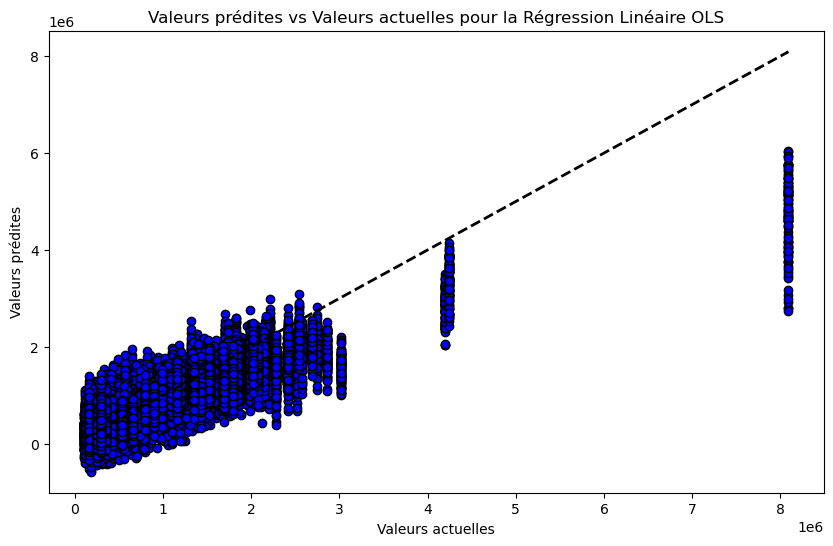

In [105]:
# Prédictions du modèle linéaire
y_pred_OLS_2 = linear_model.predict(X_urbain_train)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_OLS_2, alpha=1, color='blue', edgecolors='k')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS')
plt.show()

###### Regression de ridge 2


Best alpha for Ridge: 1000000.0
Coefficients du modèle Ridge: [-166.92386899 -219.18153569  835.11911783 ...   14.5681653  -170.03987221
   58.49107392]
Ridge Train MSE: 272343556180.0405
Ridge Train MAE: 340641.8321583226
Ridge Train R^2: 0.14821154739927633


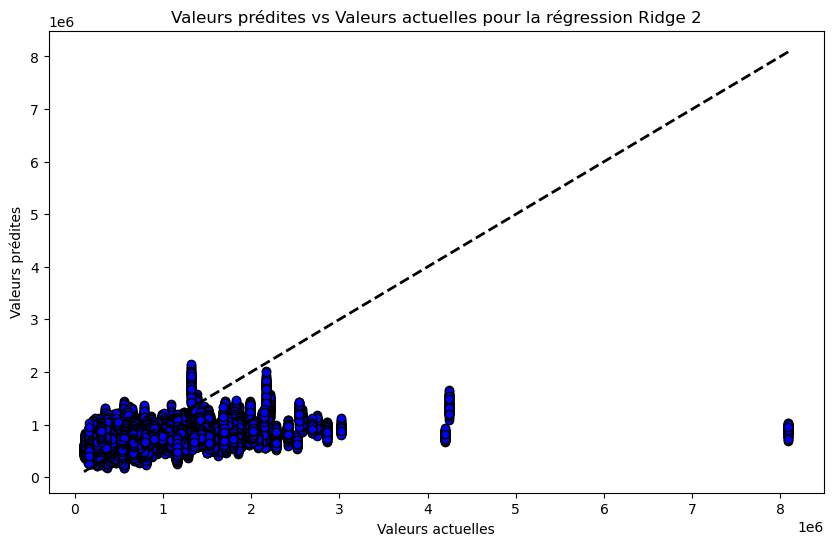

In [107]:
#Ridge regression

from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model = Ridge()

# Limite de nombre d'itérations
max_iter = 100
found_optimal_alpha = False

for i in range(max_iter):
    ridge_cv = GridSearchCV(ridge_model, {'alpha': alphas}, scoring='r2', cv=5)
    ridge_cv.fit(X_urbain_train, y)
    
    best_alpha_ridge = ridge_cv.best_estimator_.alpha
    
    if best_alpha_ridge is not None:
        found_optimal_alpha = True
        print(f'Best alpha for Ridge: {best_alpha_ridge}')
        break

if not found_optimal_alpha:
    print(f"Aucune valeur optimale pour alpha n'a été trouvée après {max_iter} itérations.")
else:
    # Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
    ridge_model = Ridge(alpha=best_alpha_ridge)
    ridge_model.fit(X_urbain_train, y)

    # Extraction et affichage des coefficients du modèle Ridge
    coefficients_ridge = ridge_model.coef_
    print("Coefficients du modèle Ridge:", coefficients_ridge)

    # Prédictions Ridge
    y_pred_ridge_2 = ridge_model.predict(X_urbain_train)

    # Évaluation du modèle Ridge
    mse_ridge = mean_squared_error(y, y_pred_ridge_2)
    r2_ridge = r2_score(y, y_pred_ridge_2)
    mae_ridge = mean_absolute_error(y, y_pred_ridge_2)

    print(f'Ridge Train MSE: {mse_ridge}')
    print(f'Ridge Train MAE: {mae_ridge}')
    print(f'Ridge Train R^2: {r2_ridge}')

    # Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred_ridge_2, alpha=1,color='blue', edgecolors='black')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
    plt.xlabel('Valeurs actuelles')
    plt.ylabel('Valeurs prédites')
    plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge 2')
    plt.show()



In [108]:
import joblib
import os
# Chemin de sauvegarde du modèle Ridge
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
ridge_model_path = os.path.join(BASE_DIR,f'{Data_milieu}','ridge_model_sans_pca.pkl')
# Sauvegarder le modèle Ridge
joblib.dump(ridge_model, ridge_model_path)
print(f'Modèle Ridge sans reduction de dimension sauvegardé à: {ridge_model_path}')

Modèle Ridge sans reduction de dimension sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\ridge_model_sans_pca.pkl


In [109]:

'''
import joblib
import os
# Chemin de chargement du modèle Ridge
ridge_model_loaded_path = os.path.join(BASE_DIR,f'{Data_milieu}','ridge_model_sans_pca.pkl')

# Recharger le modèle Ridge
ridge_model_loaded = joblib.load(ridge_model_loaded_path)
print("Modèle Ridge sans reduction de dimension chargé avec succès.")
'''


'\nimport joblib\nimport os\n# Chemin de chargement du modèle Ridge\nridge_model_loaded_path = os.path.join(BASE_DIR,f\'{Data_milieu}\',\'ridge_model_sans_pca.pkl\')\n\n# Recharger le modèle Ridge\nridge_model_loaded = joblib.load(ridge_model_loaded_path)\nprint("Modèle Ridge sans reduction de dimension chargé avec succès.")\n'

In [110]:
'''
import warnings
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-7, 7, 200)

# Limite de nombre d'itérations
max_iter = 1
found_optimal_alpha = False

# Filtrer et capturer les warnings de convergence comme des exceptions
with warnings.catch_warnings():
    warnings.filterwarnings('error', category=ConvergenceWarning)
    
    try:
        for i in range(max_iter):
            lasso_model = Lasso(max_iter=1)
            lasso_cv = GridSearchCV(lasso_model, {'alpha': alphas}, scoring='r2', cv=5)
            lasso_cv.fit(X, y)

            best_alpha_lasso = lasso_cv.best_estimator_.alpha

            if best_alpha_lasso is not None:
                found_optimal_alpha = True
                print(f'Best alpha for Lasso: {best_alpha_lasso}')
                break

        if not found_optimal_alpha:
            print(f"Aucune valeur optimale pour alpha n'a été trouvée après {max_iter} itérations.")
        else:
            # Entraîner le modèle de régression Lasso avec la meilleure valeur de alpha
            lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
            lasso_model.fit(X, y)

            # Extraction et affichage des coefficients du modèle Lasso
            coefficients_lasso = lasso_model.coef_
            print("Coefficients du modèle Lasso:", coefficients_lasso)

            # Prédictions Lasso
            y_pred_lasso_2 = lasso_model.predict(X)

            # Évaluation du modèle Lasso
            mse_lasso_2 = mean_squared_error(y, y_pred_lasso_2)
            r2_lasso_2 = r2_score(y, y_pred_lasso_2)
            mae_lasso_2 = mean_absolute_error(y, y_pred_lasso_2)

            print(f'Lasso Train MSE: {mse_lasso_2}')
            print(f'Lasso Train MAE: {mae_lasso_2}')
            print(f'Lasso Train R^2: {r2_lasso_2}')

            # Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
            plt.figure(figsize=(10, 6))
            plt.scatter(y, y_pred_lasso_2, alpha=0.5)
            plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
            plt.xlabel('Valeurs actuelles')
            plt.ylabel('Valeurs prédites')
            plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso 2')
            plt.show()
    
    except ConvergenceWarning as cw:
        print("Arrêt de l'exécution : le modèle n'a pas convergé.")
        print(str(cw))
'''

'\nimport warnings\nfrom sklearn.linear_model import Lasso, LassoCV\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom sklearn.exceptions import ConvergenceWarning\n\n# Définir une gamme de valeurs alpha à tester\nalphas = np.logspace(-7, 7, 200)\n\n# Limite de nombre d\'itérations\nmax_iter = 1\nfound_optimal_alpha = False\n\n# Filtrer et capturer les warnings de convergence comme des exceptions\nwith warnings.catch_warnings():\n    warnings.filterwarnings(\'error\', category=ConvergenceWarning)\n    \n    try:\n        for i in range(max_iter):\n            lasso_model = Lasso(max_iter=1)\n            lasso_cv = GridSearchCV(lasso_model, {\'alpha\': alphas}, scoring=\'r2\', cv=5)\n            lasso_cv.fit(X, y)\n\n            best_alpha_lasso = lasso_cv.best_estimator_.alpha\n\n            if best_alpha_lasso is not None:\n                found_opti

##### Calcul du taux de pauvreté sans réduction de dimension

In [111]:
import pandas as pd

# Création d'un nouveau DataFrame à partir des colonnes existantes
#df = pd.DataFrame({
#    'taille_menage': taille_menage,
#    'poids_menage': poids_menage,
#    'y': y,
#    'y_pred_lasso_2': y_pred_lasso_2,
#    'y_pred_OLS_2': y_pred_OLS_2,
#    'y_pred_ridge_2': y_pred_ridge_2
#})

df = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
    'y_pred_OLS_2': y_pred_OLS_2,
    'y_pred_ridge_2': y_pred_ridge_2
})

# Ajout des colonnes binaires en fonction des seuils
df['y_binaire'] = (df['y'] < 345520).astype(int)
df['y_pred_OLS_2_binaire'] = (df['y_pred_OLS_2'] < 345520).astype(int)
#df['y_pred_lasso_2_binaire'] = (df['y_pred_lasso_2'] < 345520).astype(int)
df['y_pred_ridge_2_binaire'] = (df['y_pred_ridge_2'] < 345520).astype(int)

# Calcul des taux de pauvreté
total_menage = (df['taille_menage']*df['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df['taille_menage']*df['poids_menage'] * df['y_binaire']).sum() / total_menage
taux_pauvrete_OLS_2 = (df['taille_menage']*df['poids_menage']* df['y_pred_OLS_2_binaire']).sum() / total_menage
taux_pauvrete_ridge_2 = (df['taille_menage']*df['poids_menage']* df['y_pred_ridge_2_binaire']).sum() / total_menage
#taux_pauvrete_lasso_2 = (df['taille_menage']*df['poids_menage']* df['y_pred_lasso_2_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel:.2%}")
print(f"Taux de pauvreté réel avec l'échantillon du training set: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS: {taux_pauvrete_OLS_2:.2%}")
print(f"Taux de pauvreté training prédit par Ridge: {taux_pauvrete_ridge_2:.2%}")
#print(f"Taux de pauvreté training prédit par Lasso: {taux_pauvrete_lasso_2:.2%}")


Taux de pauvreté réel: 24.65%
Taux de pauvreté réel avec l'échantillon du training set: 23.94%
Taux de pauvreté training prédit par OLS: 18.15%
Taux de pauvreté training prédit par Ridge: 0.55%


In [112]:
df

,taille_menage,poids_menage,y,y_pred_OLS_2,y_pred_ridge_2,y_binaire,y_pred_OLS_2_binaire,y_pred_ridge_2_binaire
0,5,547.83280,328734.94,3.612793e+05,681785.203048,1,0,0
1,5,547.83280,328734.94,4.095950e+05,812485.888009,1,0,0
2,5,547.83280,328734.94,5.132560e+05,730744.888746,1,0,0
3,5,547.83280,328734.94,6.443043e+05,728303.851419,1,0,0
4,5,547.83280,328734.94,1.317371e+06,816834.997871,1,0,0
...,...,...,...,...,...,...,...,...
87995,6,84.23976,532673.60,4.042345e+05,441967.868313,0,0,0
87996,6,84.23976,532673.60,8.405514e+05,425901.362741,0,0,0
87997,6,84.23976,532673.60,6.066829e+05,533727.211936,0,0,0
87998,6,84.23976,532673.60,3.886838e+05,474060.479188,0,0,0


#### OLS avec le logarithm de la consommation par tete avec réduction de la dimension

Coefficients du modèle : [ 3.99413240e-03 -1.00130356e-02  5.10484234e-03  1.08460158e-03
  3.06023855e-03  4.61603486e-03 -1.27863142e-03  1.86196701e-03
  3.00936102e-04  1.85401983e-04  5.42574859e-04 -3.73877614e-03
  5.05905277e-03 -1.04066003e-03 -3.16354227e-03 -1.44545608e-03
  4.41431715e-04 -4.87195999e-03  3.61287996e-04 -7.00361121e-04
  6.81261225e-04 -6.61534675e-03 -1.26837618e-03 -1.98904947e-05
  9.52537833e-04  6.31681466e-03  3.27243637e-03 -5.41238796e-03
  4.46211358e-05  8.55638377e-04 -1.96304801e-03  2.27904627e-03
  2.75332990e-03  2.90618702e-03  6.56591967e-03  3.77678749e-03
  2.06388368e-03  1.61289781e-04  8.82287288e-03  3.96717543e-04
 -1.14597370e-03 -6.02409603e-03 -9.03046792e-03  5.52197364e-03
  2.62823391e-03 -2.75897468e-03  8.15537068e-03  4.59993056e-03
 -4.65890614e-03 -1.73806524e-03 -9.58202251e-04 -9.87203948e-03
  4.83728210e-03 -9.42362258e-03 -1.00035134e-02 -6.43073065e-03
  1.98893569e-03 -1.85850903e-03 -9.13461773e-03 -4.66211769e-03


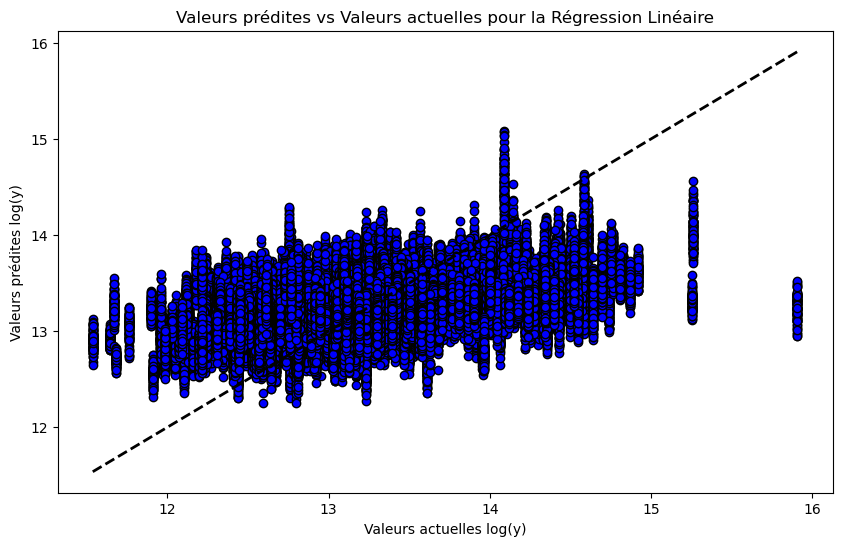

In [113]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm

# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Modèle de régression linéaire avec X_pca en tant que prédicteurs et log(y) comme variable cible.
linear_model_pca_log = LinearRegression()
linear_model_pca_log.fit(X_pca, y_log)

# Coefficients de la régression
coefficients = linear_model_pca_log.coef_
print("Coefficients du modèle :", coefficients)

# Ajout d'un intercept à X_pca
X_pca_sm = sm.add_constant(X_pca)

# Ajustement du modèle avec statsmodels pour log(y)
model_sm_pca_log = sm.OLS(y_log, X_pca_sm)
results = model_sm_pca_log.fit()

# Affichage du résumé
print(results.summary())

# Prédictions du modèle linéaire pour log(y)
y_pred_OLS_log = linear_model_pca_log.predict(X_pca)

# Calcul du MSE et du MAE
mse = mean_squared_error(y_log, y_pred_OLS_log)
mae = mean_absolute_error(y_log, y_pred_OLS_log)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_OLS_log, alpha=1, color='blue', edgecolors='k')
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire')
plt.show()


In [114]:
import pandas as pd
# Créer un DataFrame 
df_results_OLS_log = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_OLS_log': y_pred_OLS_log
})
# Afficher les 100 premières valeurs
print(df_results_OLS_log.head(100))


            y      y_log  y_pred_OLS_log
0   328734.94  12.703007       13.209103
1   328734.94  12.703007       13.156622
2   328734.94  12.703007       12.941415
3   328734.94  12.703007       13.140007
4   328734.94  12.703007       13.170980
..        ...        ...             ...
95  328734.94  12.703007       13.224740
96  328734.94  12.703007       13.192185
97  328734.94  12.703007       13.034192
98  328734.94  12.703007       13.013471
99  328734.94  12.703007       13.130250

[100 rows x 3 columns]


In [115]:
import joblib
import pickle
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Exportation du modèle OLS de statsmodels avec PCA pour ré-utilisation
model_sm_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca_log.pkl'
with open(model_sm_pca_log_path, 'wb') as file:
    pickle.dump(model_sm_pca_log, file)
print(f'Modèle statsmodels (PCA Log) sauvegardé à: {model_sm_pca_log_path}')

Modèle statsmodels (PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\model_sm_pca_log.pkl


In [116]:
'''
import joblib
import pickle
# Chemin de chargement des modèles
BASE_DIR = r'D:\Poverty_Predict'
# Chargement du modèle OLS de statsmodels avec PCA log
model_sm_pca_log_path =f'{BASE_DIR}\\{Data_milieu}\\model_sm_pca_log.pkl'
with open(model_sm_pca_log_path, 'rb') as file:
    model_sm_pca_log_loaded = pickle.load(file)
print("Modèle statsmodels (PCA Log) chargé avec succès.")
'''

'\nimport joblib\nimport pickle\n# Chemin de chargement des modèles\nBASE_DIR = r\'D:\\Poverty_Predict\'\n# Chargement du modèle OLS de statsmodels avec PCA log\nmodel_sm_pca_log_path =f\'{BASE_DIR}\\{Data_milieu}\\model_sm_pca_log.pkl\'\nwith open(model_sm_pca_log_path, \'rb\') as file:\n    model_sm_pca_log_loaded = pickle.load(file)\nprint("Modèle statsmodels (PCA Log) chargé avec succès.")\n'

#### Ridge avec le logarithm de la consommation par tete avec réduction de la dimension

Best alpha for Ridge: 1000000.0
Coefficients du modèle Ridge: [ 3.87195476e-03 -9.63940945e-03  4.86930718e-03  1.03121124e-03
  2.90130211e-03  4.34825374e-03 -1.19642924e-03  1.73561315e-03
  2.77993629e-04  1.69510603e-04  4.94346626e-04 -3.32933823e-03
  4.46045040e-03 -9.14826048e-04 -2.75707653e-03 -1.24559966e-03
  3.79559997e-04 -4.11272661e-03  3.03749326e-04 -5.72621595e-04
  5.49425910e-04 -5.29400737e-03 -1.00550972e-03 -1.54865488e-05
  7.30436738e-04  4.76457452e-03  2.42373133e-03 -3.96606349e-03
  3.24806542e-05  6.10813677e-04 -1.39290646e-03  1.58871021e-03
  1.91315038e-03  1.96800654e-03  4.39388183e-03  2.48524601e-03
  1.34878063e-03  1.04262848e-04  5.60230874e-03  2.43067679e-04
 -7.00314561e-04 -3.65870222e-03 -5.43814151e-03  3.22186966e-03
  1.50287285e-03 -1.57459543e-03  4.64539117e-03  2.55996615e-03
 -2.56358218e-03 -9.44094882e-04 -5.13161982e-04 -5.16994946e-03
  2.49375402e-03 -4.78583537e-03 -5.02089534e-03 -3.19496380e-03
  9.72052657e-04 -8.98364813

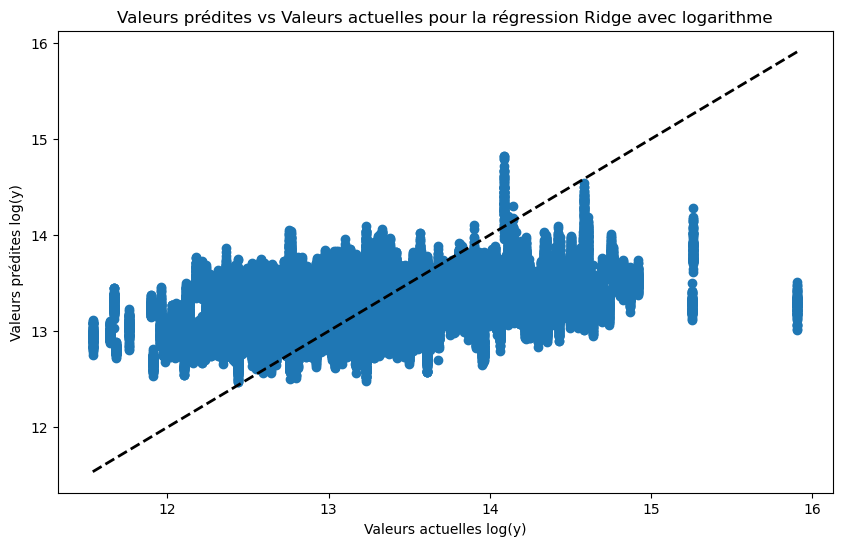

In [117]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model_pca_log = Ridge()
ridge_cv = GridSearchCV(ridge_model_pca_log, {'alpha': alphas}, scoring='r2', cv=5)
ridge_cv.fit(X_pca, y_log)

# Meilleure valeur de alpha pour Ridge
best_alpha_ridge = ridge_cv.best_estimator_.alpha
print(f'Best alpha for Ridge: {best_alpha_ridge}') 

# Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
ridge_model_pca_log = Ridge(alpha=best_alpha_ridge)
ridge_model_pca_log.fit(X_pca, y_log)

# Extraction et affichage des coefficients du modèle Ridge
coefficients_ridge = ridge_model_pca_log.coef_
print("Coefficients du modèle Ridge:", coefficients_ridge)

# Prédictions Ridge pour log(y)
y_pred_ridge_log = ridge_model_pca_log.predict(X_pca)

# Évaluation du modèle Ridge
mse_pca_ridge = mean_squared_error(y_log, y_pred_ridge_log)
r2_pca_ridge = r2_score(y_log, y_pred_ridge_log)
mae_pca_ridge = mean_absolute_error(y_log, y_pred_ridge_log)

print(f'Ridge Train MSE: {mse_pca_ridge}')
print(f'Ridge Train MAE: {mae_pca_ridge}')
print(f'Ridge Train R^2: {r2_pca_ridge}')

# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_ridge_log, alpha=1)
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge avec logarithme')
plt.show()


In [118]:
import pandas as pd
# Créer un DataFrame 
df_results_ridge_log = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_ridge_log': y_pred_ridge_log
})
# Afficher les 100 premières valeurs
print(df_results_ridge_log.head(100))

            y      y_log  y_pred_ridge_log
0   328734.94  12.703007         13.229893
1   328734.94  12.703007         13.225483
2   328734.94  12.703007         13.091312
3   328734.94  12.703007         13.198381
4   328734.94  12.703007         13.275965
..        ...        ...               ...
95  328734.94  12.703007         13.318839
96  328734.94  12.703007         13.251227
97  328734.94  12.703007         13.118793
98  328734.94  12.703007         13.113483
99  328734.94  12.703007         13.270186

[100 rows x 3 columns]


In [119]:
import joblib
import pickle
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Exportation du modèle Ridge avec PCA pour ré-utilisation
ridge_model_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca_log.pkl'
joblib.dump(ridge_model_pca_log, ridge_model_pca_log_path)
print(f'Modèle Ridge (PCA Log) sauvegardé à: {ridge_model_pca_log_path}')

Modèle Ridge (PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\ridge_model_pca_log.pkl


In [120]:
'''
import joblib
import pickle
# Chemin de chargement des modèles
BASE_DIR = r'D:\Poverty_Predict'
# Chargement du modèle Ridge avec PCA log
ridge_model_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca_log.pkl'
ridge_model_pca_log_loaded = joblib.load(ridge_model_pca_log_path)
print("Modèle Ridge (PCA Log) chargé avec succès.")
'''

'\nimport joblib\nimport pickle\n# Chemin de chargement des modèles\nBASE_DIR = r\'D:\\Poverty_Predict\'\n# Chargement du modèle Ridge avec PCA log\nridge_model_pca_log_path = f\'{BASE_DIR}\\{Data_milieu}\\ridge_model_pca_log.pkl\'\nridge_model_pca_log_loaded = joblib.load(ridge_model_pca_log_path)\nprint("Modèle Ridge (PCA Log) chargé avec succès.")\n'

Best alpha for Lasso: 0.1011637979766207
Coefficients du modèle Lasso: [ 3.71322106e-03 -9.66797558e-03  4.67422018e-03  6.23684425e-04
  2.57255475e-03  4.06779214e-03 -6.66979834e-04  1.21386499e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.64396821e-03
  3.86432897e-03 -0.00000000e+00 -1.85109181e-03 -1.70640171e-05
  0.00000000e+00 -3.22852227e-03  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -4.39337961e-03 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00  3.41651692e-03  1.55125591e-04 -2.16589945e-03
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.16516851e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.70519777e-03  0.00000000e+00
 -0.00000000e+00 -2.68581040e-04 -3.14971295e-03  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  1.42885610e-03  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -1.77525760e-03
  0.00000000e+00 -7.96601442e-04 -1.16896757e-03 -0.00000000e+00
  0.00000000e+00 -0

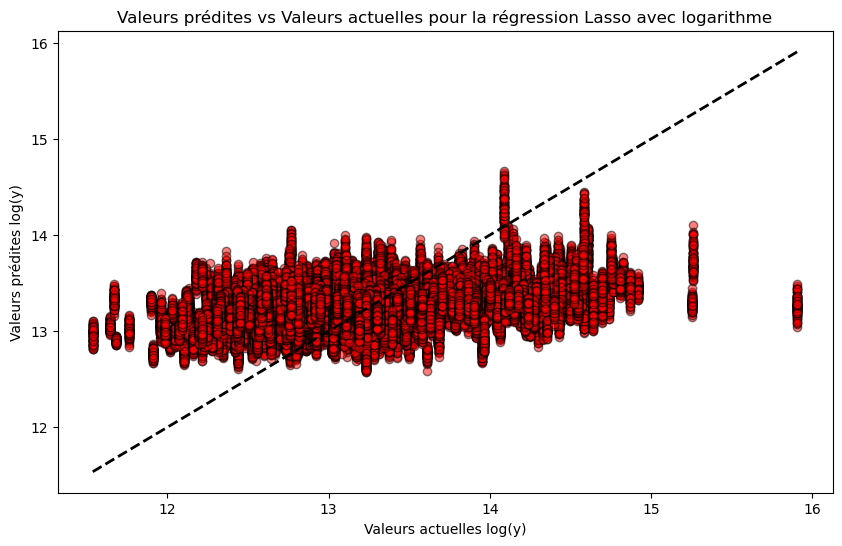

In [121]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
lasso_model_pca_log = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(lasso_model_pca_log, {'alpha': alphas}, scoring='r2', cv=5)
lasso_cv.fit(X_pca, y_log)

# Meilleure valeur de alpha pour Lasso
best_alpha_lasso = lasso_cv.best_estimator_.alpha
print(f'Best alpha for Lasso: {best_alpha_lasso}')

# Entraîner le modèle de régression Lasso avec la meilleure valeur de alpha
lasso_model_pca_log = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model_pca_log.fit(X_pca, y_log)

# Extraction et affichage des coefficients du modèle Lasso
coefficients_lasso = lasso_model_pca_log.coef_
print("Coefficients du modèle Lasso:", coefficients_lasso)

# Prédictions Lasso pour log(y)
y_pred_lasso_log = lasso_model_pca_log.predict(X_pca)

# Évaluation du modèle Lasso
mse_pca_lasso = mean_squared_error(y_log, y_pred_lasso_log)
r2_pca_lasso = r2_score(y_log, y_pred_lasso_log)
mae_pca_lasso = mean_absolute_error(y_log, y_pred_lasso_log)

print(f'Lasso Train MSE: {mse_pca_lasso}')
print(f'Lasso Train MAE: {mae_pca_lasso}')
print(f'Lasso Train R^2: {r2_pca_lasso}')

# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_lasso_log, alpha=0.5,color='red',edgecolors='black')
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Lasso avec logarithme')
plt.show()


In [123]:
import joblib
import pickle
# Chemin de sauvegarde des modèles

BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
# Exportation du modèle Lasso avec PCA pour ré-utilisation
lasso_model_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca_log.pkl'
joblib.dump(lasso_model_pca_log, lasso_model_pca_log_path)
print(f'Modèle Lasso (PCA Log) sauvegardé à: {lasso_model_pca_log_path}')

Modèle Lasso (PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\lasso_model_pca_log.pkl


In [124]:
'''
import joblib
import pickle
# Chemin de chargement des modèles
BASE_DIR = r'D:\Poverty_Predict'
# Chargement du modèle Lasso avec PCA log
lasso_model_pca_log_path ='f'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca_log.pkl'
lasso_model_pca_log_loaded = joblib.load(lasso_model_pca_log_path)
print("Modèle Lasso (PCA Log) chargé avec succès.")
'''

'\nimport joblib\nimport pickle\n# Chemin de chargement des modèles\nBASE_DIR = r\'D:\\Poverty_Predict\'\n# Chargement du modèle Lasso avec PCA log\nlasso_model_pca_log_path =\'f\'{BASE_DIR}\\{Data_milieu}\\lasso_model_pca_log.pkl\'\nlasso_model_pca_log_loaded = joblib.load(lasso_model_pca_log_path)\nprint("Modèle Lasso (PCA Log) chargé avec succès.")\n'

In [125]:
import pandas as pd
# Créer un DataFrame 
df_results_ridge_log = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_lasso_log': y_pred_lasso_log
})
# Afficher les 100 premières valeurs
print(df_results_ridge_log.head(100))

            y      y_log  y_pred_lasso_log
0   328734.94  12.703007         13.298247
1   328734.94  12.703007         13.327826
2   328734.94  12.703007         13.262728
3   328734.94  12.703007         13.294537
4   328734.94  12.703007         13.408097
..        ...        ...               ...
95  328734.94  12.703007         13.392709
96  328734.94  12.703007         13.331255
97  328734.94  12.703007         13.220031
98  328734.94  12.703007         13.235648
99  328734.94  12.703007         13.403653

[100 rows x 3 columns]


In [126]:
import pandas as pd

# Création d'un nouveau DataFrame à partir des colonnes existantes
df2 = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
	'y_log': y_log,
	'y_pred_OLS_log': y_pred_OLS_log,
    'y_pred_lasso_log': y_pred_lasso_log,
    'y_pred_ridge_log': y_pred_ridge_log
})

# Ajout des colonnes binaires en fonction des seuils
seuil=np.log(345520)
df2['y_log_binaire'] = (df2['y_log'] < seuil).astype(int)
df2['y_pred_OLS_log_binaire'] = (df2['y_pred_OLS_log'] < seuil).astype(int)
df2['y_pred_lasso_log_binaire'] = (df2['y_pred_lasso_log'] < seuil).astype(int)
df2['y_pred_ridge_log_binaire'] = (df2['y_pred_ridge_log'] < seuil).astype(int)

# Calcul des taux de pauvreté
total_menage = (df2['taille_menage']*df2['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df2['taille_menage']*df2['poids_menage'] * df2['y_log_binaire']).sum() / total_menage
taux_pauvrete_OLS_log = (df2['taille_menage']*df2['poids_menage']* df2['y_pred_OLS_log_binaire']).sum() / total_menage
taux_pauvrete_ridge_log = (df2['taille_menage']*df2['poids_menage']* df2['y_pred_ridge_log_binaire']).sum() / total_menage
taux_pauvrete_lasso_log = (df2['taille_menage']*df2['poids_menage']* df2['y_pred_lasso_log_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel:.2%}")
print(f"Taux de pauvreté réel avec l'échantillon du training set: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS logarithme consommation par tete: {taux_pauvrete_OLS_log:.2%}")
print(f"Taux de pauvreté training prédit par Ridge logarithme consommation par tete: {taux_pauvrete_ridge_log:.2%}")
print(f"Taux de pauvreté training prédit par Lasso logarithme consommation par tete: {taux_pauvrete_lasso_log:.2%}")

Taux de pauvreté réel: 24.65%
Taux de pauvreté réel avec l'échantillon du training set: 23.94%
Taux de pauvreté training prédit par OLS logarithme consommation par tete: 2.58%
Taux de pauvreté training prédit par Ridge logarithme consommation par tete: 0.89%
Taux de pauvreté training prédit par Lasso logarithme consommation par tete: 0.31%


#### OLS avec le logarithm de la consommation par tete sans réduction de la dimension


Coefficients du modèle : [-1258.94627361 -2015.39945133  2194.22104189 ... -2790.00252001
  4556.63333623 -7344.97721556]
                            OLS Regression Results                            
Dep. Variable:                  pcexp   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     39.20
Date:                Wed, 28 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:33:52   Log-Likelihood:                -37991.
No. Observations:               88000   AIC:                         8.410e+04
Df Residuals:                   83939   BIC:                         1.222e+05
Df Model:                        4060                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------

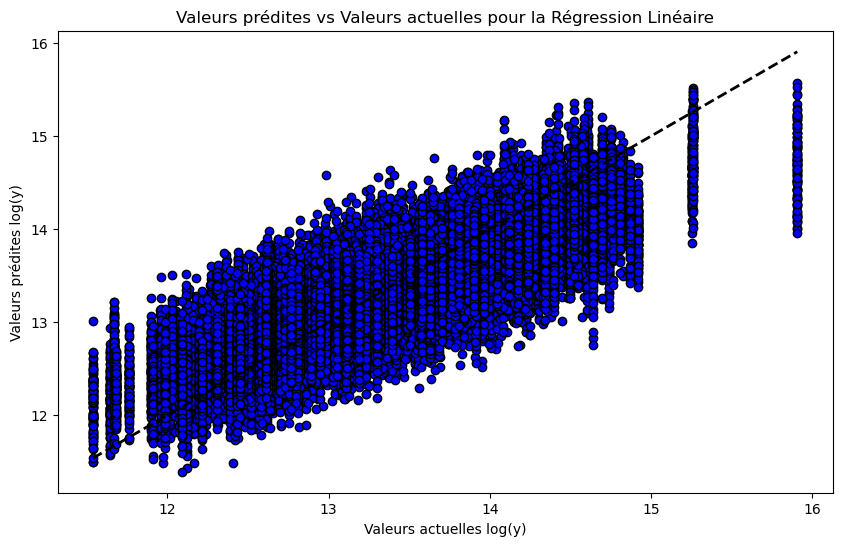

            y      y_log  y_pred_OLS_log_sans_pca
0   328734.94  12.703007                12.964787
1   328734.94  12.703007                12.342141
2   328734.94  12.703007                12.715982
3   328734.94  12.703007                12.781946
4   328734.94  12.703007                13.191635
..        ...        ...                      ...
95  328734.94  12.703007                13.195974
96  328734.94  12.703007                13.366868
97  328734.94  12.703007                12.385547
98  328734.94  12.703007                12.829229
99  328734.94  12.703007                13.328353

[100 rows x 3 columns]


In [127]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import pandas as pd
import pickle



# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Modèle de régression linéaire avec X en tant que prédicteurs et log(y) comme variable cible.
linear_model_sans_pca_log = LinearRegression()
linear_model_sans_pca_log.fit(X_urbain_train, y_log)

# Coefficients de la régression
coefficients = linear_model_sans_pca_log.coef_
print("Coefficients du modèle :", coefficients)

# Ajout d'un intercept à X
X_sm = sm.add_constant(X_urbain_train)

# Ajustement du modèle avec statsmodels pour log(y)
model_sm_sans_pca_log = sm.OLS(y_log, X_sm)
results = model_sm_sans_pca_log.fit()

# Affichage du résumé
print(results.summary())

# Prédictions du modèle linéaire pour log(y)
y_pred_OLS_log_sans_pca = linear_model_sans_pca_log.predict(X_urbain_train)

# Calcul du MSE et du MAE
mse = mean_squared_error(y_log, y_pred_OLS_log_sans_pca)
mae = mean_absolute_error(y_log, y_pred_OLS_log_sans_pca)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_OLS_log_sans_pca, alpha=1, color='blue', edgecolors='k')
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire')
plt.show()

# Créer un DataFrame 
df_results_OLS_log_sans_pca = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_OLS_log_sans_pca': y_pred_OLS_log_sans_pca
})
# Afficher les 100 premières valeurs
print(df_results_OLS_log_sans_pca.head(100))




In [128]:
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'
# Exportation du modèle OLS de statsmodels sans PCA pour ré-utilisation
model_sm_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_sans_pca_log.pkl'
with open(model_sm_sans_pca_log_path, 'wb') as file:
    pickle.dump(model_sm_sans_pca_log, file)
print(f'Modèle statsmodels (sans PCA Log) sauvegardé à: {model_sm_sans_pca_log_path}')



Modèle statsmodels (sans PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\model_sm_sans_pca_log.pkl


In [129]:
''' 
model_sm_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\model_sm_sans_pca_log.pkl'
# Chargement du modèle OLS de statsmodels sans PCA log
with open(model_sm_sans_pca_log_path, 'rb') as file:
    model_sm_sans_pca_log_loaded = pickle.load(file)
print("Modèle statsmodels (sans PCA Log) chargé avec succès.")
'''

' \nmodel_sm_sans_pca_log_path = f\'{BASE_DIR}\\{Data_milieu}\\model_sm_sans_pca_log.pkl\'\n# Chargement du modèle OLS de statsmodels sans PCA log\nwith open(model_sm_sans_pca_log_path, \'rb\') as file:\n    model_sm_sans_pca_log_loaded = pickle.load(file)\nprint("Modèle statsmodels (sans PCA Log) chargé avec succès.")\n'

#### Regression de ridge avec le logarithm de la consommation par tete sans réduction de la dimension


Best alpha for Ridge: 1000000.0
Coefficients du modèle Ridge: [-9.31577121e-05 -3.20542651e-04  6.84984608e-04 ...  2.88087346e-04
 -1.75854055e-04 -2.85798421e-05]
Ridge Train MSE: 0.32667727454663176
Ridge Train MAE: 0.4582809997745181
Ridge Train R^2: 0.1875102353014042


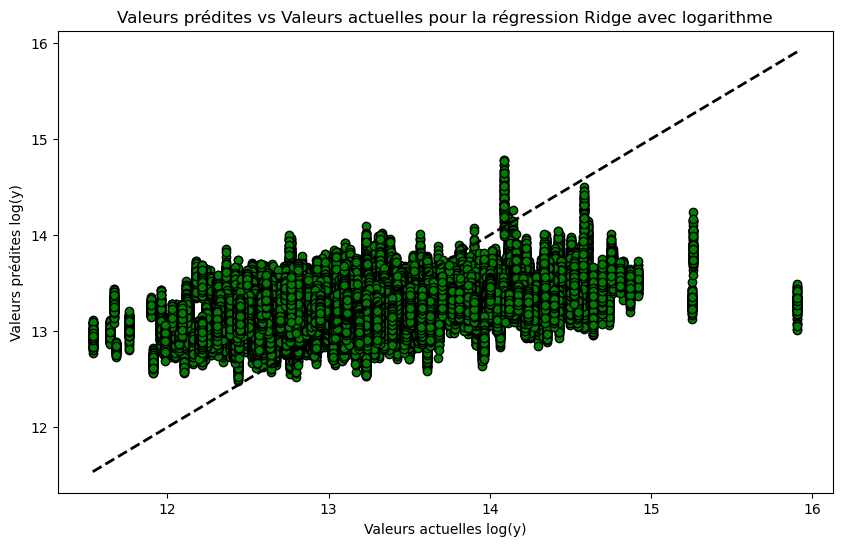

            y      y_log  y_pred_ridge_log_sans_pca
0   328734.94  12.703007                  13.208854
1   328734.94  12.703007                  13.243069
2   328734.94  12.703007                  13.114978
3   328734.94  12.703007                  13.208827
4   328734.94  12.703007                  13.296946
..        ...        ...                        ...
95  328734.94  12.703007                  13.315628
96  328734.94  12.703007                  13.264747
97  328734.94  12.703007                  13.140514
98  328734.94  12.703007                  13.114640
99  328734.94  12.703007                  13.307818

[100 rows x 3 columns]


In [130]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import pickle


# Transformation de la variable cible y en log(y)
y_log = np.log(y)

# Définir une gamme de valeurs alpha à tester
alphas = np.logspace(-6, 6, 200)

# Configuration initiale et recherche du meilleur alpha avec GridSearchCV
ridge_model_sans_pca_log = Ridge()
ridge_cv = GridSearchCV(ridge_model_sans_pca_log, {'alpha': alphas}, scoring='r2', cv=5)
ridge_cv.fit(X_urbain_train, y_log)

# Meilleure valeur de alpha pour Ridge
best_alpha_ridge = ridge_cv.best_estimator_.alpha
print(f'Best alpha for Ridge: {best_alpha_ridge}') 

# Entraîner le modèle de régression Ridge avec la meilleure valeur de alpha
ridge_model_sans_pca_log = Ridge(alpha=best_alpha_ridge)
ridge_model_sans_pca_log.fit(X_urbain_train, y_log)

# Extraction et affichage des coefficients du modèle Ridge
coefficients_ridge = ridge_model_sans_pca_log.coef_
print("Coefficients du modèle Ridge:", coefficients_ridge)

# Prédictions Ridge pour log(y)
y_pred_ridge_log_sans_pca = ridge_model_sans_pca_log.predict(X_urbain_train)

# Évaluation du modèle Ridge
mse_sans_pca_ridge = mean_squared_error(y_log, y_pred_ridge_log_sans_pca)
r2_sans_pca_ridge = r2_score(y_log, y_pred_ridge_log_sans_pca)
mae_sans_pca_ridge = mean_absolute_error(y_log, y_pred_ridge_log_sans_pca)

print(f'Ridge Train MSE: {mse_sans_pca_ridge}')
print(f'Ridge Train MAE: {mae_sans_pca_ridge}')
print(f'Ridge Train R^2: {r2_sans_pca_ridge}')

# Graphe montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y_log, y_pred_ridge_log_sans_pca, alpha=1,color='green',edgecolors='black')
plt.plot([y_log.min(), y_log.max()], [y_log.min(), y_log.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles log(y)')
plt.ylabel('Valeurs prédites log(y)')
plt.title('Valeurs prédites vs Valeurs actuelles pour la régression Ridge avec logarithme')
plt.show()

# Créer un DataFrame 
df_results_ridge_log_sans_pca = pd.DataFrame({
    'y': y,
    'y_log': y_log,
    'y_pred_ridge_log_sans_pca': y_pred_ridge_log_sans_pca
})
# Afficher les 100 premières valeurs
print(df_results_ridge_log_sans_pca.head(100))



In [131]:
# Chemin de sauvegarde des modèles
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Exportation du modèle Ridge sans PCA pour ré-utilisation
ridge_model_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_sans_pca_log.pkl'
joblib.dump(ridge_model_sans_pca_log, ridge_model_sans_pca_log_path)
print(f'Modèle Ridge (sans PCA Log) sauvegardé à: {ridge_model_sans_pca_log_path}')




Modèle Ridge (sans PCA Log) sauvegardé à: D:\Poverty_Predict_Par_Milieu\Data_urbain\ridge_model_sans_pca_log.pkl


In [132]:
'''
BASE_DIR = r'D:\Poverty_Predict_Par_Milieu'

# Chargement du modèle Ridge sans PCA log
ridge_model_sans_pca_log_path = f'{BASE_DIR}\\{Data_milieu}\\ridge_model_sans_pca_log.pkl'

ridge_model_sans_pca_log_loaded = joblib.load(ridge_model_sans_pca_log_path)
print("Modèle Ridge (sans PCA Log) chargé avec succès.")
'''

'\nBASE_DIR = r\'D:\\Poverty_Predict_Par_Milieu\'\n\n# Chargement du modèle Ridge sans PCA log\nridge_model_sans_pca_log_path = f\'{BASE_DIR}\\{Data_milieu}\\ridge_model_sans_pca_log.pkl\'\n\nridge_model_sans_pca_log_loaded = joblib.load(ridge_model_sans_pca_log_path)\nprint("Modèle Ridge (sans PCA Log) chargé avec succès.")\n'

In [133]:
import pandas as pd
import numpy as np

# Supposons que taille_menage, poids_menage, y, y_log, y_pred_OLS_log_sans_pca et y_pred_ridge_log_sans_pca sont déjà définis ici

# Création d'un nouveau DataFrame à partir des colonnes existantes
df3 = pd.DataFrame({
    'taille_menage': taille_menage,
    'poids_menage': poids_menage,
    'y': y,
    'y_log': y_log,
    'y_pred_OLS_log_sans_pca': y_pred_OLS_log_sans_pca,
    'y_pred_ridge_log_sans_pca': y_pred_ridge_log_sans_pca
})

# Définir le seuil en utilisant la valeur log(345520)
seuil = np.log(345520)

# Ajouter les colonnes binaires en fonction des seuils
df3['y_log_binaire'] = (df3['y_log'] < seuil).astype(int)
df3['y_pred_OLS_log_sans_pca_binaire'] = (df3['y_pred_OLS_log_sans_pca'] < seuil).astype(int)
df3['y_pred_ridge_log_sans_pca_binaire'] = (df3['y_pred_ridge_log_sans_pca'] < seuil).astype(int)

# Calcul des taux de pauvreté
total_menage = (df3['taille_menage'] * df3['poids_menage']).sum()
taux_pauvrete_reel_echantillon = (df3['taille_menage'] * df3['poids_menage'] * df3['y_log_binaire']).sum() / total_menage
taux_pauvrete_OLS_log = (df3['taille_menage'] * df3['poids_menage'] * df3['y_pred_OLS_log_sans_pca_binaire']).sum() / total_menage
taux_pauvrete_ridge_log = (df3['taille_menage'] * df3['poids_menage'] * df3['y_pred_ridge_log_sans_pca_binaire']).sum() / total_menage

# Affichage des résultats
print(f"Taux de pauvreté réel: {taux_pauvrete_reel_echantillon:.2%}")
print(f"Taux de pauvreté training prédit par OLS logarithme consommation par tête (sans PCA): {taux_pauvrete_OLS_log:.2%}")
print(f"Taux de pauvreté training prédit par Ridge logarithme consommation par tête (sans PCA): {taux_pauvrete_ridge_log:.2%}")


Taux de pauvreté réel: 23.94%
Taux de pauvreté training prédit par OLS logarithme consommation par tête (sans PCA): 16.21%
Taux de pauvreté training prédit par Ridge logarithme consommation par tête (sans PCA): 0.75%


#### vérification du problème avec les graphes

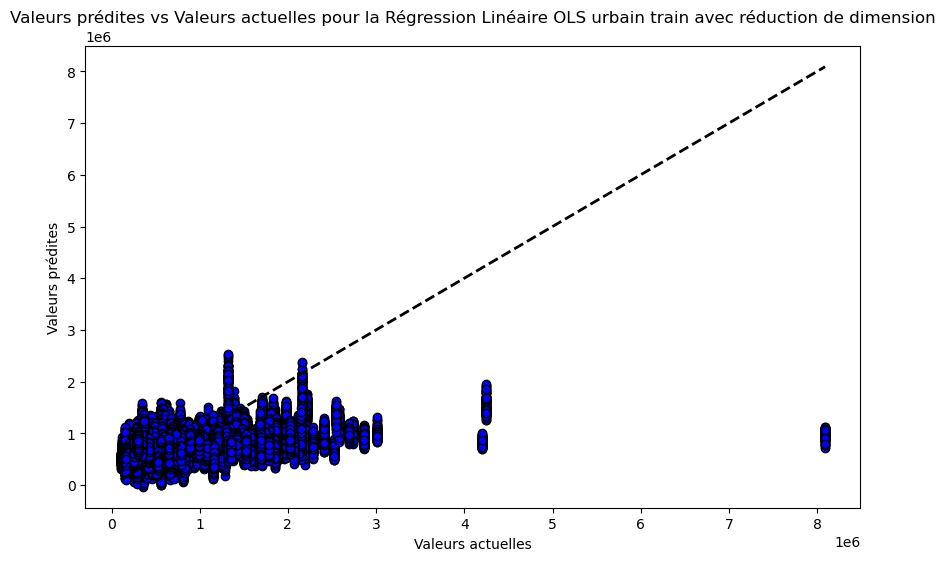

In [134]:
# Prédictions du modèle linéaire prédiction avec OLS avec réduction de dimension

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_OLS, alpha=1, color='blue', edgecolors='Black')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS urbain train avec réduction de dimension')
plt.show()

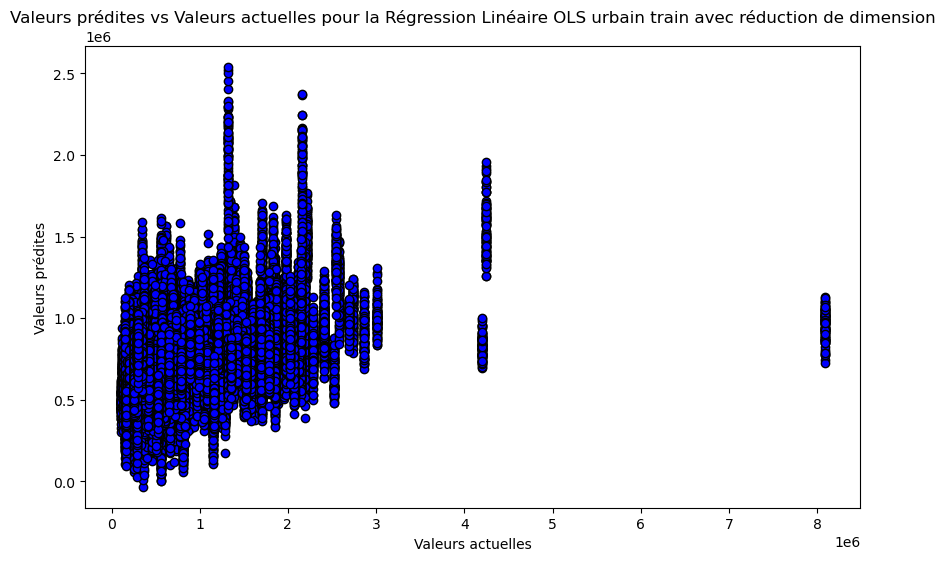

In [135]:
# Prédictions du modèle linéaire prédiction avec OLS avec réduction de dimension

# Graphique montrant la relation entre les valeurs prédites et les valeurs actuelles
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_OLS, alpha=1, color='blue', edgecolors='Black')
#plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Ligne de référence parfaite
plt.xlabel('Valeurs actuelles')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs Valeurs actuelles pour la Régression Linéaire OLS urbain train avec réduction de dimension')
plt.show()